In [1]:
#installations
!pip install pandas
!pip install numpy

In [18]:
#imports
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, KFold

In [287]:
#data
data=pd.read_excel("C:/Users/eliza/OneDrive/Documents/Perceptions of UofF Research/July Research Update 2024/Data.xlsx")

#remove rows with NA entries
data=data.dropna() 

#remove PQ8 (non-binarized col)
data=data.drop(['PQ8'],axis=1)
        
data.shape

(1350, 19)

In [288]:
data.head()

Group  TypeOfForce  OfficersPresent  Resistance  StateOfControl  \
0      1          5.0             2.00         5.0             1.0   
1      2         17.0             2.00         5.0             1.0   
2      2          8.0            10.00         5.0             1.0   
3      2         16.0             0.99         0.0             1.0   
4      1          1.0             3.00         5.0             1.0   

   SuspectArmed  DeEscalation  DetainCiteArrest   PQ1  PQ2  PQ3  PQ4  PQ5  \
0           0.0           1.0               2.0   7.0  1.0  3.0  3.0  5.0   
1           0.0           0.0               4.0   2.0  0.0  3.0  4.0  2.0   
2           4.0           0.0               4.0   1.0  0.0  9.0  9.0  1.0   
3           0.0           0.0               4.0   1.0  0.0  4.0  5.0  4.0   
4           0.0           1.0               4.0  10.0  1.0  1.0  1.0  1.0   

    PQ6  PQ7  PQ8_binary  PQ9  PQ10  PQ11  
0   2.0  1.0           1  1.0   1.0   2.0  
1  10.0  4.0           1  2.0   1.0   1.0  
2   5.0  1.0           0  5.0   4.0   5.0  
3   5.0  6.0           0  2.0   2.0   2.0  
4   1.0  1.0           1  1.0   1.0   1.0

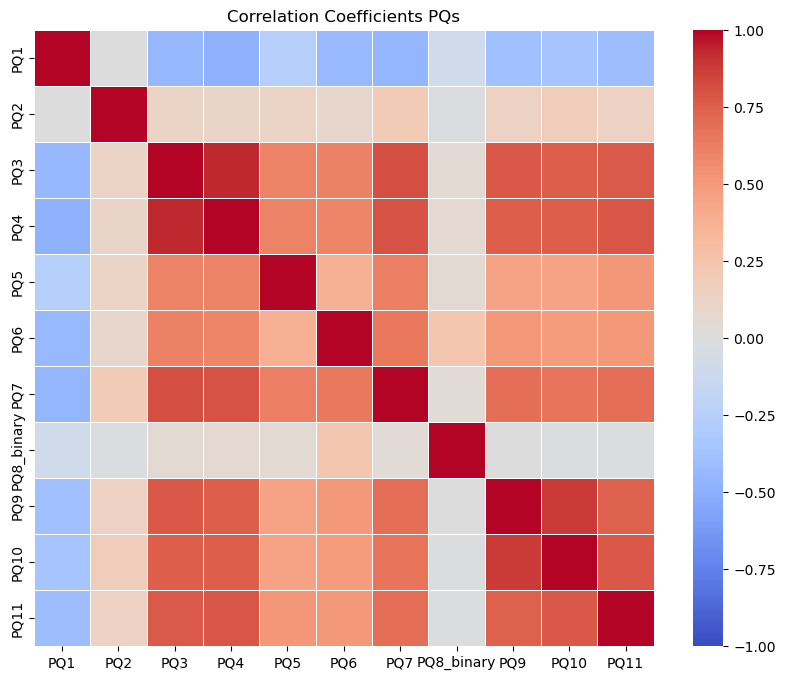

In [289]:
#visualize correlation coefficient matrix for PQs
PQs_df = data[['PQ1','PQ2','PQ3','PQ4','PQ5','PQ6','PQ7','PQ8_binary','PQ9','PQ10','PQ11']]
spearman_corr = PQs_df.corr(method='spearman')
plt.figure(figsize=(10, 8))
sns.heatmap(spearman_corr, annot=False, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Coefficients PQs')
plt.show()

In [ ]:
#run factor analysis to group PQs (start with model containing all possible factors)

In [290]:
PQs_df.head()

PQ1  PQ2  PQ3  PQ4  PQ5   PQ6  PQ7  PQ8_binary  PQ9  PQ10  PQ11
0   7.0  1.0  3.0  3.0  5.0   2.0  1.0           1  1.0   1.0   2.0
1   2.0  0.0  3.0  4.0  2.0  10.0  4.0           1  2.0   1.0   1.0
2   1.0  0.0  9.0  9.0  1.0   5.0  1.0           0  5.0   4.0   5.0
3   1.0  0.0  4.0  5.0  4.0   5.0  6.0           0  2.0   2.0   2.0
4  10.0  1.0  1.0  1.0  1.0   1.0  1.0           1  1.0   1.0   1.0

In [265]:
#run KMO test to see if PQs_df is suitable for factor analysis (it is - close to 1)
!pip install factor-analyzer

In [266]:
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer.factor_analyzer import FactorAnalyzer

In [291]:
calculate_kmo(PQs_df)

(array([0.94371537, 0.897349  , 0.8858825 , 0.88829617, 0.960481  ,
        0.9073928 , 0.92877041, 0.37338006, 0.89956685, 0.8924555 ,
        0.96497927]),
 0.9088840983308806)

In [349]:
#construct factor model 

#rotation : varimax, quartimax, equamax (orthogonal)
#rotation : promax, direct oblimin, oblimax, quartimin (non-orthogonal)

factor_model = FactorAnalyzer(n_factors=11, rotation='varimax')
factor_model.fit(PQs_df)

FactorAnalyzer(n_factors=11, rotation='varimax', rotation_kwargs={})

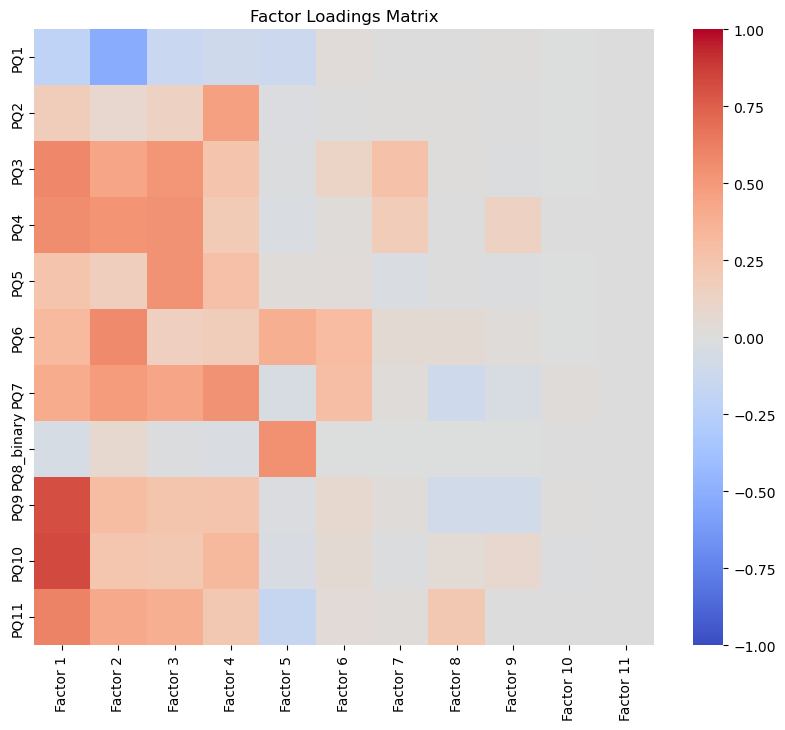

In [350]:
#obtain the loadings of each variable on each factor 
loadings = factor_model.loadings_
loadings_df = pd.DataFrame(loadings, index=PQs_df.columns, columns=[f'Factor {i+1}' for i in range(loadings.shape[1])])
plt.figure(figsize=(10, 8))
sns.heatmap(loadings_df, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Factor Loadings Matrix')
plt.show()

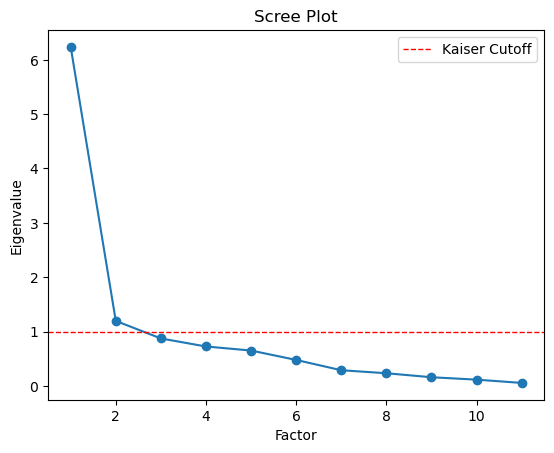

In [351]:
#obtain the scree plot of the variance explained by each factor (eigenvalues)
ev, v = factor_model.get_eigenvalues()
plt.plot(range(1, PQs_df.shape[1] + 1), ev, marker='o')
plt.xlabel('Factor')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot')
plt.axhline(y=1, color='red', linestyle='--', linewidth=1, label='Kaiser Cutoff')
plt.legend()
plt.show()

#by Kaisser criterion, we only should utilize 2 factors

In [352]:
ev

array([6.23694495, 1.19463918, 0.87212006, 0.72419862, 0.64968206,
       0.47692122, 0.28722959, 0.23190417, 0.15843046, 0.1141706 ,
       0.05375907])

In [ ]:
#try to construct model with K = 4 (since we are trying to group PQs based on Graham Factors)

In [383]:
factor_model_reduced = FactorAnalyzer(n_factors=4, rotation='varimax')
factor_model_reduced.fit(PQs_df)

FactorAnalyzer(n_factors=4, rotation='varimax', rotation_kwargs={})

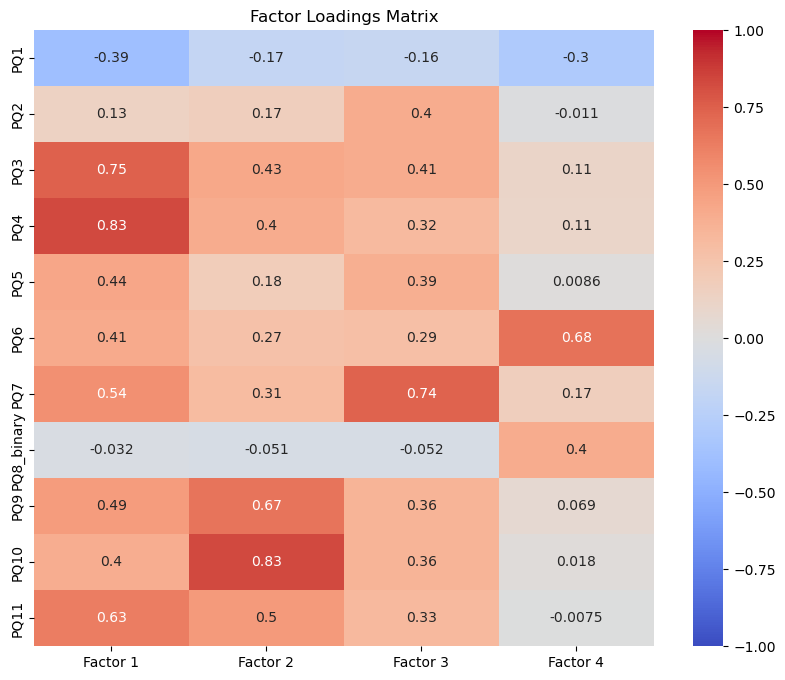

In [384]:
#obtain the loadings of each variable on each factor 
loadings = factor_model_reduced.loadings_
loadings_df = pd.DataFrame(loadings, index=PQs_df.columns, columns=[f'Factor {i+1}' for i in range(loadings.shape[1])])
plt.figure(figsize=(10, 8))
sns.heatmap(loadings_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Factor Loadings Matrix')
plt.show()

In [69]:
#assess model fit (accuracy of factor loadings)

In [385]:
#split PQs_df into training and testing sets to compare fitted factor scores to predicted factor scores
from sklearn.model_selection import train_test_split
train_PQs, test_PQs = train_test_split(PQs_df, test_size=0.259) 

In [ ]:
#obtain list of predicted factor scores from 5-fold CV on training set

In [386]:
train_PQs = train_PQs.reset_index(drop=True)

In [387]:
predicted_scores_CV = []

In [388]:
for i in range(1,6,1):

    test_fold_i = train_PQs.iloc[200*i - 200 : 200*i, :]
    test_indices = train_PQs.index[200*i - 200 : 200*i]
    train_fold_i = train_PQs.drop(test_indices)
    
    factormodel_i = FactorAnalyzer(n_factors=4, rotation='varimax')
    factormodel_i.fit(train_fold_i)
    
    loadings_fold_i = factormodel_i.loadings_
    factormodel_i_scores = np.dot(test_fold_i, loadings_fold_i)
    
    predicted_scores_CV.append(factormodel_i_scores)
    
predicted_scores_CV_df = pd.concat([pd.DataFrame(scores) for scores in predicted_scores_CV], ignore_index=True)
predicted_scores_CV_df.columns = ["F1 CV Scores", "F2 CV Scores","F3 CV Scores","F4 CV Scores"]
predicted_scores_CV_df

F1 CV Scores  F2 CV Scores  F3 CV Scores  F4 CV Scores
0       11.912005     10.292766     10.306230      6.499657
1        3.795567      4.076838      4.810621      0.130295
2        5.665869      8.185367      5.348808     -0.489690
3       25.815076     22.110965     20.967201      7.831864
4        5.682431      5.186883      4.608020      1.217341
..            ...           ...           ...           ...
995      2.458673      3.546904      3.677673     -0.905524
996      1.951916      3.465983      3.780649     -1.461670
997     17.545874     14.223175     14.871037      8.004831
998      4.524800      4.350869      6.133301     -1.633795
999     15.360087     13.987179     15.416190      4.636996

[1000 rows x 4 columns]

In [ ]:
#obtain list of predicted scores on test set

In [390]:
factormodel_test_set=FactorAnalyzer(n_factors=4, rotation='varimax')
factormodel_test_set.fit(test_PQs)
loadings_test_set = factormodel_test_set.loadings_
factormodel_test_scores = np.dot(train_PQs, loadings_test_set)
factormodel_test_scores_df = pd.DataFrame(factormodel_test_scores, columns=["F1 Test Scores", "F2 Test Scores","F3 Test Scores","F4 Test Scores"])
factormodel_test_scores_df

F1 Test Scores  F2 Test Scores  F3 Test Scores  F4 Test Scores
0         14.025885        9.247069        7.482730        5.985295
1          4.148119        4.038946        4.456937        0.639894
2          5.497179        8.419514        3.630558       -0.536535
3         29.235323       20.889395       14.511188        8.467838
4          6.377521        4.956434        2.847068        1.371911
..              ...             ...             ...             ...
995        2.773190        3.743579        2.846170       -0.415771
996        2.201301        3.822041        2.856595       -0.954749
997       20.373316       12.898551        9.328776        8.891842
998        5.685820        4.440573        4.035383       -0.745436
999       18.158670       13.099184        9.850546        5.849990

[1000 rows x 4 columns]

In [391]:
#construct data frames to compare scores
F1_scores = pd.concat([predicted_scores_CV_df[['F1 CV Scores']], factormodel_test_scores_df[['F1 Test Scores']]], axis=1)
F2_scores = pd.concat([predicted_scores_CV_df[['F2 CV Scores']], factormodel_test_scores_df[['F2 Test Scores']]], axis=1)
F3_scores = pd.concat([predicted_scores_CV_df[['F3 CV Scores']], factormodel_test_scores_df[['F3 Test Scores']]], axis=1)
F4_scores = pd.concat([predicted_scores_CV_df[['F4 CV Scores']], factormodel_test_scores_df[['F4 Test Scores']]], axis=1)

In [392]:
#compare both sets of scores using correlation coefficient 
F1_correlation = F1_scores['F1 CV Scores'].corr(F1_scores['F1 Test Scores'],method='spearman')
print(f"Spearman's Correlation Coefficient for F1 Scores: {F1_correlation}")

Spearman's Correlation Coefficient for F1 Scores: 0.9877649910480663


In [393]:
F2_correlation = F2_scores['F2 CV Scores'].corr(F2_scores['F2 Test Scores'],method='spearman')
print(f"Spearman's Correlation Coefficient for F2 Scores: {F2_correlation}")

Spearman's Correlation Coefficient for F2 Scores: 0.985940264276524


In [394]:
F3_correlation = F3_scores['F3 CV Scores'].corr(F3_scores['F3 Test Scores'],method='spearman')
print(f"Spearman's Correlation Coefficient for F3 Scores: {F3_correlation}")

Spearman's Correlation Coefficient for F3 Scores: 0.9887427443966019


In [395]:
#compare both sets of scores using correlation coefficient 
F4_correlation = F4_scores['F4 CV Scores'].corr(F4_scores['F4 Test Scores'],method='spearman')
print(f"Spearman's Correlation Coefficient for F4 Scores: {F4_correlation}")

Spearman's Correlation Coefficient for F4 Scores: 0.9765136753252235


In [ ]:
#based on our results, our loadings are good estimates 

In [138]:
#get column number (indexed from 0) of var for preprocessing
data.columns.get_loc("PQ2")

21

In [139]:
#pre-processing

#re-define ordinal outcome variable (PQ#) as binary using cut-off
for i in range(1273):
    if data.iloc[i,21]<=3:
        data.iloc[i,21]=0
    else:
        data.iloc[i,21]=1

#re-define categorical predictors as several classes of binary

#Coding Groups: Group 1: Watch/Annotate/Perceptions ,, Group 2: Annotate/Watch/Perceptions
Group1=pd.DataFrame(columns=['Group1'],index=range(1273))
for i in range(1273):
    if data.iloc[i,0]==1:
        Group1.loc[i]=1
    else: 
        Group1.loc[i]=0
        
Group2=pd.DataFrame(columns=['Group2'],index=range(1273))
for i in range(1273):
    if data.iloc[i,0]==2:
        Group2.loc[i]=1
    else:
        Group2.loc[i]=0

#Suspectrace
WhiteSuspect=pd.DataFrame(columns=['WhiteSuspect'],index=range(1273))
for i in range(1273):
    if data.iloc[i,1]==1:
        WhiteSuspect.loc[i]=1
    else:
        WhiteSuspect.loc[i]=0

BlackSuspect=pd.DataFrame(columns=['BlackSuspect'],index=range(1273))
for i in range(1273):
    if data.iloc[i,1]==2:
        BlackSuspect.loc[i]=1
    else:
        BlackSuspect.loc[i]=0

AmerIndAlNatSuspect=pd.DataFrame(columns=['AmerIndAlNatSuspect'],index=range(1273))
for i in range(1273):
    if data.iloc[i,1]==3:
        AmerIndAlNatSuspect.loc[i]=1
    else:
        AmerIndAlNatSuspect.loc[i]=0

NatHiPacIsSuspect=pd.DataFrame(columns=['NatHiPacIsSuspect'],index=range(1273))
for i in range(1273):
    if data.iloc[i,1]==4:
        NatHiPacIsSuspect.loc[i]=1
    else:
        NatHiPacIsSuspect.loc[i]=0
        
AsianSuspect=pd.DataFrame(columns=['AsianSuspect'],index=range(1273))
for i in range(1273):
    if data.iloc[i,1]==5:
        AsianSuspect.loc[i]=1
    else:
        AsianSuspect.loc[i]=0
        
MidEasternSuspect=pd.DataFrame(columns=['MidEasternSuspect'],index=range(1273))
for i in range(1273):
    if data.iloc[i,1]==6:
        MidEasternSuspect.loc[i]=1
    else:
        MidEasternSuspect.loc[i]=0
        
UnknownRaceSuspect=pd.DataFrame(columns=['UnknownRaceSuspect'],index=range(1273))
for i in range(1273):
    if data.iloc[i,1]==7:
        UnknownRaceSuspect.loc[i]=1
    else:
        UnknownRaceSuspect.loc[i]=0

OtherRaceSuspect=pd.DataFrame(columns=['OtherRaceSuspect'],index=range(1273))
for i in range(1273):
    if data.iloc[i,1]==8:
        OtherRaceSuspect.loc[i]=1
    else:
        OtherRaceSuspect.loc[i]=0

Suspectrace=pd.concat([WhiteSuspect,BlackSuspect,AmerIndAlNatSuspect,NatHiPacIsSuspect,AsianSuspect,MidEasternSuspect,UnknownRaceSuspect,OtherRaceSuspect],axis=1)

#Suspectgender
UnknownSuspectGender=pd.DataFrame(columns=['UnknownSuspectGender'],index=range(1273))
for i in range(1273):
    if data.iloc[i,2]==8:
        UnknownSuspectGender.loc[i]=1
    else:
        UnknownSuspectGender.loc[i]=0

FemaleSuspect=pd.DataFrame(columns=['FemaleSuspect'],index=range(1273))
for i in range(1273):
    if data.iloc[i,2]==0:
        FemaleSuspect.loc[i]=1
    else:
        FemaleSuspect.loc[i]=0
        
MaleSuspect=pd.DataFrame(columns=['MaleSuspect'],index=range(1273))
for i in range(1273):
    if data.iloc[i,2]==1:
        MaleSuspect.loc[i]=1
    else:
        MaleSuspect.loc[i]=0

Suspectgender=pd.concat([UnknownSuspectGender,FemaleSuspect,MaleSuspect],axis=1)
        
#TypeOfForce
OffVerbalThreat=pd.DataFrame(columns=['OffVerbalThreat'],index=range(1273))
for i in range(1273):
    if data.iloc[i,4]==1:
        OffVerbalThreat.loc[i]=1
    else:
        OffVerbalThreat.loc[i]=0

OffPatDown=pd.DataFrame(columns=['OffPatDown'],index=range(1273))
for i in range(1273):
    if data.iloc[i,4]==2:
        OffPatDown.loc[i]=1
    else:
        OffPatDown.loc[i]=0

OffFirmGrip=pd.DataFrame(columns=['OffFirmGrip'],index=range(1273))
for i in range(1273):
    if data.iloc[i,4]==3:
        OffFirmGrip.loc[i]=1
    else:
        OffFirmGrip.loc[i]=0
        
OffPainCompliance=pd.DataFrame(columns=['OffPainCompliance'],index=range(1273))
for i in range(1273):
    if data.iloc[i,4]==4:
        OffPainCompliance.loc[i]=1
    else:
        OffPainCompliance.loc[i]=0
        
OffControlPushThrow=pd.DataFrame(columns=['OffControlPushThrow'],index=range(1273))
for i in range(1273):
    if data.iloc[i,4]==5:
        OffControlPushThrow.loc[i]=1
    else:
        OffControlPushThrow.loc[i]=0

OffUncontrolPushThrow=pd.DataFrame(columns=['OffUncontrolPushThrow'],index=range(1273))
for i in range(1273):
    if data.iloc[i,4]==6:
        OffUncontrolPushThrow.loc[i]=1
    else:
        OffUncontrolPushThrow.loc[i]=0

OffLVNR=pd.DataFrame(columns=['OffLVNR'],index=range(1273))
for i in range(1273):
    if data.iloc[i,4]==7:
        OffLVNR.loc[i]=1
    else:
        OffLVNR.loc[i]=0

OffStrikeHandsFeet=pd.DataFrame(columns=['OffStrikeHandsFeet'],index=range(1273))
for i in range(1273):
    if data.iloc[i,4]==8:
        OffStrikeHandsFeet.loc[i]=1
    else:
        OffStrikeHandsFeet.loc[i]=0

OffStrikeInstrument=pd.DataFrame(columns=['OffStrikeInstrument'],index=range(1273))
for i in range(1273):
    if data.iloc[i,4]==9:
        OffStrikeInstrument.loc[i]=1
    else:
        OffStrikeInstrument.loc[i]=0
        
OffUnknownForce=pd.DataFrame(columns=['OffUnknownForce'],index=range(1273))
for i in range(1273):
    if data.iloc[i,4]==11:
        OffUnknownForce.loc[i]=1
    else:
        OffUnknownForce.loc[i]=0
        
OffTaser=pd.DataFrame(columns=['OffTaser'],index=range(1273))
for i in range(1273):
    if data.iloc[i,4]==10:
        OffTaser.loc[i]=1
    else:
        OffTaser.loc[i]=0

OffPepperSpray=pd.DataFrame(columns=['OffPepperSpray'],index=range(1273))
for i in range(1273):
    if data.iloc[i,4]==12:
        OffPepperSpray.loc[i]=1
    else:
        OffPepperSpray.loc[i]=0
        
OffFirearmDrawn=pd.DataFrame(columns=['OffFirearmDrawn'],index=range(1273))
for i in range(1273):
    if data.iloc[i,4]==13:
        OffFirearmDrawn.loc[i]=1
    else:
        OffFirearmDrawn.loc[i]=0
        
OffFirearmUsed=pd.DataFrame(columns=['OffFirearmUsed'],index=range(1273))
for i in range(1273):
    if data.iloc[i,4]==14:
        OffFirearmUsed.loc[i]=1
    else:
        OffFirearmUsed.loc[i]=0
        
OffDisplayNonLethal=pd.DataFrame(columns=['OffDisplayNonLethal'],index=range(1273))
for i in range(1273):
    if data.iloc[i,4]==15:
        OffDisplayNonLethal.loc[i]=1
    else:
        OffDisplayNonLethal.loc[i]=0
        
OffUnknownForce2=pd.DataFrame(columns=['OffUnknownForce2'],index=range(1273))
for i in range(1273):
    if data.iloc[i,4]==16:
        OffUnknownForce2.loc[i]=1
    else:
        OffUnknownForce2.loc[i]=0
        
OffOtherForce=pd.DataFrame(columns=['OffOtherForce'],index=range(1273))
for i in range(1273):
    if data.iloc[i,4]==17:
        OffOtherForce.loc[i]=1
    else:
        OffOtherForce.loc[i]=0
        
TypeOfForce=pd.concat([OffVerbalThreat,OffPatDown,OffFirmGrip,OffPainCompliance,OffControlPushThrow,OffUncontrolPushThrow,OffLVNR,OffStrikeHandsFeet,OffStrikeInstrument,OffUnknownForce,OffTaser,OffPepperSpray,OffFirearmDrawn,OffFirearmUsed,OffDisplayNonLethal,OffUnknownForce2,OffOtherForce],axis=1)
        
#SuspectArmed
SuspectUnarmed=pd.DataFrame(columns=['SuspectUnarmed'],index=range(1273))
for i in range(1273):
    if data.iloc[i,12]==0:
        SuspectUnarmed.loc[i]=1
    else:
        SuspectUnarmed.loc[i]=0
        
SuspectDisplayWeapon=pd.DataFrame(columns=['SuspectDisplayWeapon'],index=range(1273))
for i in range(1273):
    if data.iloc[i,12]==1:
        SuspectDisplayWeapon.loc[i]=1
    else:
        SuspectDisplayWeapon.loc[i]=0
        
SuspectUsingWeapon=pd.DataFrame(columns=['SuspectUsingWeapon'],index=range(1273))
for i in range(1273):
    if data.iloc[i,12]==2:
        SuspectUsingWeapon.loc[i]=1
    else:
        SuspectUsingWeapon.loc[i]=0
        
OffFoundSuspectWeapon=pd.DataFrame(columns=['OffFoundSuspectWeapon'],index=range(1273))
for i in range(1273):
    if data.iloc[i,12]==3:
        OffFoundSuspectWeapon.loc[i]=1
    else:
        OffFoundSuspectWeapon.loc[i]=0
        
SuspectWeaponOther=pd.DataFrame(columns=['SuspectWeaponOther'],index=range(1273))
for i in range(1273):
    if data.iloc[i,12]==4:
        SuspectWeaponOther.loc[i]=1
    else:
        SuspectWeaponOther.loc[i]=0

Suspectarmed=pd.concat([SuspectUnarmed,SuspectDisplayWeapon,SuspectUsingWeapon,OffFoundSuspectWeapon,SuspectWeaponOther],axis=1)

#TypeofDeEscalationTech
OffNoDeEscalation=pd.DataFrame(columns=['OffNoDeEscalation'],index=range(1273))
for i in range(1273):
    if data.iloc[i,14]==0:
        OffNoDeEscalation.loc[i]=1
    else:
        OffNoDeEscalation.loc[i]=0
        
OffPhysicalDeEscalation=pd.DataFrame(columns=['OffPhysicalDeEscalation'],index=range(1273))
for i in range(1273):
    if data.iloc[i,14]==1:
        OffPhysicalDeEscalation.loc[i]=1
    else:
        OffPhysicalDeEscalation.loc[i]=0
        
OffVerbalDeEscalation=pd.DataFrame(columns=['OffVerbalDeEscalation'],index=range(1273))
for i in range(1273):
    if data.iloc[i,14]==2:
        OffVerbalDeEscalation.loc[i]=1
    else:
        OffVerbalDeEscalation.loc[i]=0
        
OffOtherDeEscalation=pd.DataFrame(columns=['OffOtherDeEscalation'],index=range(1273))
for i in range(1273):
    if data.iloc[i,14]==3:
        OffOtherDeEscalation.loc[i]=1
    else:
        OffOtherDeEscalation.loc[i]=0
        
TypeofDeEscalationTechnique=pd.concat([OffNoDeEscalation,OffPhysicalDeEscalation, OffVerbalDeEscalation, OffOtherDeEscalation],axis=1)

#OverallAssessment
OffSilentAfterForce=pd.DataFrame(columns=['OffSilentAfterForce'],index=range(1273))
for i in range(1273):
    if data.iloc[i,17]==1:
        OffSilentAfterForce.loc[i]=1
    else:
        OffSilentAfterForce.loc[i]=0
        
OffReassuringAfterForce=pd.DataFrame(columns=['OffReassuringAfterForce'],index=range(1273))
for i in range(1273):
    if data.iloc[i,17]==2:
        OffReassuringAfterForce.loc[i]=1
    else:
        OffReassuringAfterForce.loc[i]=0
        
OffAnnoyedAfterForce=pd.DataFrame(columns=['OffAnnoyedAfterForce'],index=range(1273))
for i in range(1273):
    if data.iloc[i,17]==3:
        OffAnnoyedAfterForce.loc[i]=1
    else:
        OffAnnoyedAfterForce.loc[i]=0
        
OffAngryAfterForce=pd.DataFrame(columns=['OffAngryAfterForce'],index=range(1273))
for i in range(1273):
    if data.iloc[i,17]==4:
        OffAngryAfterForce.loc[i]=1
    else:
        OffAngryAfterForce.loc[i]=0
        
OffOtherAfterForce=pd.DataFrame(columns=['OffOtherAfterForce'],index=range(1273))
for i in range(1273):
    if data.iloc[i,17]==5:
        OffOtherAfterForce.loc[i]=1
    else:
        OffOtherAfterForce.loc[i]=0
        
OverallAssessment=pd.concat([OffSilentAfterForce,OffReassuringAfterForce,OffAnnoyedAfterForce,OffAngryAfterForce,OffOtherAfterForce],axis=1)

#DetainCiteArrest
NoArrest=pd.DataFrame(columns=['NoArrest'],index=range(1273))
for i in range(1273):
    if data.iloc[i,18]==0:
        NoArrest.loc[i]=1
    else:
        NoArrest.loc[i]=0
        
DetainedNoCuffs=pd.DataFrame(columns=['DetainedNoCuffs'],index=range(1273))
for i in range(1273):
    if data.iloc[i,18]==1:
        DetainedNoCuffs.loc[i]=1
    else:
        DetainedNoCuffs.loc[i]=0
        
DetainedCuffs=pd.DataFrame(columns=['DetainedCuffs'],index=range(1273))
for i in range(1273):
    if data.iloc[i,18]==2:
        DetainedCuffs.loc[i]=1
    else:
        DetainedCuffs.loc[i]=0
        
VerbalStatementArrest=pd.DataFrame(columns=['VerbalStatementArrest'],index=range(1273))
for i in range(1273):
    if data.iloc[i,18]==3:
        VerbalStatementArrest.loc[i]=1
    else:
        VerbalStatementArrest.loc[i]=0
        
PhysicalArrestCuffs=pd.DataFrame(columns=['PhysicalArrestCuffs'],index=range(1273))
for i in range(1273):
    if data.iloc[i,18]==4:
        PhysicalArrestCuffs.loc[i]=1
    else:
        PhysicalArrestCuffs.loc[i]=0
        
GivenCitation=pd.DataFrame(columns=['GivenCitation'],index=range(1273))
for i in range(1273):
    if data.iloc[i,18]==5:
        GivenCitation.loc[i]=1
    else:
        GivenCitation.loc[i]=0
        
OtherDetainment=pd.DataFrame(columns=['OtherDetainment'],index=range(1273))
for i in range(1273):
    if data.iloc[i,18]==6:
        OtherDetainment.loc[i]=1
    else:
        OtherDetainment.loc[i]=0
        
DetainCiteArrest=pd.concat([NoArrest,DetainedNoCuffs,DetainedCuffs,VerbalStatementArrest,PhysicalArrestCuffs,GivenCitation,OtherDetainment],axis=1)
        
#Systematic Racism Q 6
PushTooFast=pd.DataFrame(columns=['PushTooFast'],index=range(1273))
for i in range(1273):
    if data.iloc[i,95]==1:
        PushTooFast.loc[i]=0
    else:
        PushTooFast.loc[i]=1
        
GoingTooSlow=pd.DataFrame(columns=['GoingTooSlow'],index=range(1273))
for i in range(1273):
    if data.iloc[i,95]==2:
        GoingTooSlow.loc[i]=0
    else:
        GoingTooSlow.loc[i]=1
        
MovingRightSpeed=pd.DataFrame(columns=['MovingRightSpeed'],index=range(1273))
for i in range(1273):
    if data.iloc[i,95]==3:
        MovingRightSpeed.loc[i]=0
    else:
        MovingRightSpeed.loc[i]=1

symracismq6=pd.concat([PushTooFast,GoingTooSlow,MovingRightSpeed],axis=1)
        
#CoderPolitics
CoderLiberal=pd.DataFrame(columns=['CoderLiberal'],index=range(1273))
for i in range(1273):
    if data.iloc[i,100]==1:
        CoderLiberal.loc[i]=1
    else:
        CoderLiberal.loc[i]=0
        
CoderIndependent=pd.DataFrame(columns=['CoderIndependent'],index=range(1273))
for i in range(1273):
    if data.iloc[i,100]==2:
        CoderIndependent.loc[i]=1
    else:
        CoderIndependent.loc[i]=0
        
CoderConservative=pd.DataFrame(columns=['CoderConservative'],index=range(1273))
for i in range(1273):
    if data.iloc[i,100]==3:
        CoderConservative.loc[i]=1
    else:
        CoderConservative.loc[i]=0
        
CoderPoliticsOther=pd.DataFrame(columns=['CoderPoliticsOther'],index=range(1273))
for i in range(1273):
    if data.iloc[i,100]==4:
        CoderPoliticsOther.loc[i]=1
    else:
        CoderPoliticsOther.loc[i]=0
        
Coderpolitics=pd.concat([CoderLiberal,CoderIndependent,CoderConservative,CoderPoliticsOther],axis=1)

#Coderrace
WhiteCoder=pd.DataFrame(columns=['WhiteCoder'],index=range(1273))
for i in range(1273):
    if data.iloc[i,101]==1:
        WhiteCoder.loc[i]=1
    else:
        WhiteCoder.loc[i]=0
        
AfricanBlackCoder=pd.DataFrame(columns=['AfricanBlackCoder'],index=range(1273))
for i in range(1273):
    if data.iloc[i,101]==2:
        AfricanBlackCoder.loc[i]=1
    else:
        AfricanBlackCoder.loc[i]=0
        
HispanicLatinoCoder=pd.DataFrame(columns=['HispanicLatinoCoder'],index=range(1273))
for i in range(1273):
    if data.iloc[i,101]==3:
        HispanicLatinoCoder.loc[i]=1
    else:
        HispanicLatinoCoder.loc[i]=0
        
AsianCoder=pd.DataFrame(columns=['AsianCoder'],index=range(1273))
for i in range(1273):
    if data.iloc[i,101]==4:
        AsianCoder.loc[i]=1
    else:
        AsianCoder.loc[i]=0
        
NativeAmericanCoder=pd.DataFrame(columns=['NativeAmericanCoder'],index=range(1273))
for i in range(1273):
    if data.iloc[i,101]==5:
        NativeAmericanCoder.loc[i]=1
    else:
        NativeAmericanCoder.loc[i]=0
        
MidEastNorthAfrCoder=pd.DataFrame(columns=['MidEastNorthAfrCoder'],index=range(1273))
for i in range(1273):
    if data.iloc[i,101]==6:
        MidEastNorthAfrCoder.loc[i]=1
    else:
        MidEastNorthAfrCoder.loc[i]=0
        
PacificIslanderCoder=pd.DataFrame(columns=['PacificIslanderCoder'],index=range(1273))
for i in range(1273):
    if data.iloc[i,101]==7:
        PacificIslanderCoder.loc[i]=1
    else:
        PacificIslanderCoder.loc[i]=0
        
OtherCoderrace=pd.DataFrame(columns=['OtherCoderrace'],index=range(1273))
for i in range(1273):
    if data.iloc[i,101]==8:
        OtherCoderrace.loc[i]=1
    else:
        OtherCoderrace.loc[i]=0
        
NoDiscloseCoderrace=pd.DataFrame(columns=['NoDiscloseCoderrace'],index=range(1273))
for i in range(1273):
    if data.iloc[i,101]==9:
        NoDiscloseCoderrace.loc[i]=1
    else:
        NoDiscloseCoderrace.loc[i]=0
        
WhiteandHispLatinoCoder=pd.DataFrame(columns=['WhiteandHispLatinoCoder'],index=range(1273))
for i in range(1273):
    if data.iloc[i,101]==10:
        WhiteandHispLatinoCoder.loc[i]=1
    else:
        WhiteandHispLatinoCoder.loc[i]=0
        
WhiteandMidEastNorAfrCoder=pd.DataFrame(columns=['WhiteandMidEastNorAfrCoder'],index=range(1273))
for i in range(1273):
    if data.iloc[i,101]==11:
        WhiteandMidEastNorAfrCoder.loc[i]=1
    else:
        WhiteandMidEastNorAfrCoder.loc[i]=0
        
Coderrace=pd.concat([WhiteCoder,AfricanBlackCoder,HispanicLatinoCoder,AsianCoder,NativeAmericanCoder,MidEastNorthAfrCoder,PacificIslanderCoder,OtherCoderrace,NoDiscloseCoderrace,WhiteandHispLatinoCoder,WhiteandMidEastNorAfrCoder],axis=1)

#CoderCorps
WSUCorpsCurrent=pd.DataFrame(columns=['WSUCorpsCurrent'],index=range(1273))
for i in range(1273):
    if data.iloc[i,104]==1:
        WSUCorpsCurrent.loc[i]=1
    else:
        WSUCorpsCurrent.loc[i]=0
        
WSUCorpsPrevious=pd.DataFrame(columns=['WSUCorpsPrevious'],index=range(1273))
for i in range(1273):
    if data.iloc[i,104]==2:
        WSUCorpsPrevious.loc[i]=1
    else:
        WSUCorpsPrevious.loc[i]=0
        
WSUNoCorps=pd.DataFrame(columns=['WSUNoCorps'],index=range(1273))
for i in range(1273):
    if data.iloc[i,104]==0:
        WSUNoCorps.loc[i]=1
    else:
        WSUNoCorps.loc[i]=0
        
CoderCorps=pd.concat([WSUCorpsCurrent,WSUCorpsPrevious,WSUNoCorps],axis=1)

In [140]:
#re-construct data with binary variables

#drop categorical predictors
data=data.drop(['Suspectrace','Group','Suspectgender','TypeOfForce','SuspectArmed','TypeofDeEscalationTech','OverallAssessment','DetainCiteArrest','symracismq6','Coderpolitics','Coderrace','Codercorps'],axis=1)

#concatentate new data frame with classes of binaries predictors
data=pd.concat([data.reset_index(drop=True),Suspectrace.reset_index(drop=True), Suspectgender.reset_index(drop=True), TypeOfForce.reset_index(drop=True), Suspectarmed.reset_index(drop=True), TypeofDeEscalationTechnique.reset_index(drop=True), OverallAssessment.reset_index(drop=True), DetainCiteArrest.reset_index(drop=True), symracismq6.reset_index(drop=True), Coderpolitics.reset_index(drop=True), Coderrace.reset_index(drop=True), CoderCorps.reset_index(drop=True),Group1.reset_index(drop=True),Group2.reset_index(drop=True)],axis=1)

#see data
data.shape

(1273, 179)

In [81]:
data.head(10)

Videonewsstory  LengthofVideoInSeconds  ForceLocation  LocNoiseLevel  \
0             0.0                  1211.0            1.0            2.0   
1             1.0                  1211.0            1.0            2.0   
2             0.0                  1211.0            1.0            1.0   
3             1.0                  1211.0            1.0            2.0   
4             1.0                  1211.0            0.0            2.0   
5             0.0                  1211.0            1.0            3.0   
6             1.0                  1211.0            1.0            2.0   
7             0.0                  1211.0            1.0            2.0   
8             1.0                  1211.0            1.0            2.0   
9             1.0                  1211.0            1.0            2.0   

   LocationIsolated  Bystanders  OfficersPresent  Resistance  StateOfControl  \
0               0.0         3.0              5.0         0.0             1.0   
1               0.0         4.0              7.0         0.0             0.0   
2               0.0         4.0              3.0         0.0             1.0   
3               0.0         4.0              1.0         0.0             1.0   
4               0.0         3.0              1.0         0.0             1.0   
5               0.0         4.0              2.0         0.0             1.0   
6               0.0         4.0              1.0         0.0             1.0   
7               0.0         4.0              6.0         0.0             1.0   
8               0.0         4.0              1.0         0.0             1.0   
9               0.0         4.0              4.0         0.0             1.0   

   DeEscalation  ...  PacificIslanderCoder  OtherCoderrace  \
0           0.0  ...                     0               0   
1           0.0  ...                     0               0   
2           1.0  ...                     0               0   
3           0.0  ...                     0               0   
4           0.0  ...                     0               0   
5           0.0  ...                     0               0   
6           0.0  ...                     0               0   
7           0.0  ...                     0               0   
8           0.0  ...                     0               0   
9           0.0  ...                     0               0   

   NoDiscloseCoderrace  WhiteandHispLatinoCoder  WhiteandMidEastNorAfrCoder  \
0                    0                        0                           0   
1                    0                        0                           0   
2                    0                        0                           0   
3                    0                        0                           0   
4                    0                        0                           0   
5                    0                        0                           0   
6                    0                        0                           0   
7                    0                        0                           0   
8                    0                        0                           0   
9                    0                        0                           0   

   WSUCorpsCurrent  WSUCorpsPrevious  WSUNoCorps  Group1  Group2  
0                0                 0           1       0       1  
1                1                 0           0       0       1  
2                0                 0           1       1       0  
3                0                 0           1       1       0  
4                0                 0           1       0       1  
5                0                 0           1       1       0  
6                1                 0           0       1       0  
7                0                 0           1       0       1  
8                1                 0           0       1       0  
9                1                 0           0       1       0  

[10 r

In [46]:
#find max and min of data
max_cols=data.columns[data.max()==data.max().max()]
max_cols

Index(['LengthofVideoInSeconds'], dtype='object')

In [ ]:
#rescale columns in cols_to_be_scaled to be from [-1,1]
data['LengthofVideoInSeconds'] = data['LengthofVideoInSeconds'] / data['LengthofVideoInSeconds'].max()
data['LengthofVideoInSeconds']

In [225]:
#begin k-fold cross-validation

#select explanatory and response vars
X=data.drop(['PQ1'], axis=1) #explanatory vars
y=data['PQ1'] #response

#split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.214)

In [226]:
#define subset of data to build folds out of
y_train=pd.DataFrame(y_train,columns=['PQ1'])
y_train.head()
y_train.shape

training_data=pd.concat([X_train,y_train],axis=1)
training_data.shape

(1000, 179)

In [227]:
#reset indices of training data from 1 instead of 0 
training_data.reset_index(drop = True, inplace = True)
training_data.index=training_data.index + 1
training_data.head(10)

Videonewsstory  LengthofVideoInSeconds  ForceLocation  LocNoiseLevel  \
1              0.0                0.169617            0.0            3.0   
2              1.0                0.176054            0.0            2.0   
3              1.0                0.052140            0.0            2.0   
4              0.0                0.141938            0.0            3.0   
5              0.0                0.132926            0.0            2.0   
6              0.0                0.308014            0.0            3.0   
7              0.0                0.132926            0.0            1.0   
8              0.0                0.169617            0.0            2.0   
9              0.0                0.112327            0.0            2.0   
10             0.0                0.144834            0.0            3.0   

    LocationIsolated  Bystanders  OfficersPresent  Resistance  StateOfControl  \
1                0.0         2.0              2.0         0.0             1.0   
2                1.0         1.0              1.0         0.0             1.0   
3                0.0         1.0              3.0         1.0             1.0   
4                0.0         2.0              3.0         5.0             1.0   
5                0.0         0.0              2.0         0.0             1.0   
6                1.0         0.0              6.0         2.0             1.0   
7                0.0         1.0              2.0         1.0             1.0   
8                0.0         1.0              2.0         1.0             1.0   
9                0.0         3.0              3.0         2.0             1.0   
10               0.0         1.0              1.0         2.0             1.0   

    DeEscalation  ...  OtherCoderrace  NoDiscloseCoderrace  \
1            1.0  ...               0                    0   
2            0.0  ...               0                    0   
3            0.0  ...               0                    0   
4            1.0  ...               0                    0   
5            0.0  ...               0                    0   
6            1.0  ...               0                    0   
7            0.0  ...               0                    0   
8            1.0  ...               0                    0   
9            0.0  ...               0                    0   
10           0.0  ...               0                    0   

    WhiteandHispLatinoCoder  WhiteandMidEastNorAfrCoder  WSUCorpsCurrent  \
1                         0                           0                0   
2                         0                           0                1   
3                         0                           0                0   
4                         0                           0                0   
5                         0                           0                0   
6                         0                           0                0   
7                         0                           0                0   
8                         0                           0                0   
9                         0                           0                1   
10                        0                           0                0   

    WSUCorpsPrevious  WSUNoCorps  Group1  Group2  PQ1  
1                  0           1       0       1  1.0  
2                  0           0       1       0  1.0  
3                  0           1       1       0  1.0  
4                  0           1       1       0  1.0  
5                  0           1       0       1  1.0  
6                  0           1       1       0  1.0  
7                  0           1       0       1  1.0  
8                  0           1       1       0  0.0  
9                  0           0       0       1  1.0  
10                 0           1       0       1  1.0  

[10 rows x 179 columns]

In [624]:
#define parameters for grid search and five-fold cross-validation results dictionary
from sklearn import svm, datasets
model_SVC = svm.SVC()
import itertools
import time
from sklearn.metrics import matthews_corrcoef

parameters = {'kernel':['poly'],'C':[0.001,0.01,0.1,0.3,0.5,0.7], 'gamma':[0.001,0.01,0.1,0.3,0.5,0.7],'degree':[2,3]}
cv_result_dict={'params' : list(itertools.product(*[parameters[k] for k in parameters])),
               'fold_1_predictions':[],
               'fold_2_predictions':[],
               'fold_3_predictions':[],
               'fold_4_predictions':[],
               'fold_5_predictions':[],
               }
cv_result_dict

{'params': [('poly', 0.001, 0.001, 2),
  ('poly', 0.001, 0.001, 3),
  ('poly', 0.001, 0.01, 2),
  ('poly', 0.001, 0.01, 3),
  ('poly', 0.001, 0.1, 2),
  ('poly', 0.001, 0.1, 3),
  ('poly', 0.001, 0.3, 2),
  ('poly', 0.001, 0.3, 3),
  ('poly', 0.001, 0.5, 2),
  ('poly', 0.001, 0.5, 3),
  ('poly', 0.001, 0.7, 2),
  ('poly', 0.001, 0.7, 3),
  ('poly', 0.01, 0.001, 2),
  ('poly', 0.01, 0.001, 3),
  ('poly', 0.01, 0.01, 2),
  ('poly', 0.01, 0.01, 3),
  ('poly', 0.01, 0.1, 2),
  ('poly', 0.01, 0.1, 3),
  ('poly', 0.01, 0.3, 2),
  ('poly', 0.01, 0.3, 3),
  ('poly', 0.01, 0.5, 2),
  ('poly', 0.01, 0.5, 3),
  ('poly', 0.01, 0.7, 2),
  ('poly', 0.01, 0.7, 3),
  ('poly', 0.1, 0.001, 2),
  ('poly', 0.1, 0.001, 3),
  ('poly', 0.1, 0.01, 2),
  ('poly', 0.1, 0.01, 3),
  ('poly', 0.1, 0.1, 2),
  ('poly', 0.1, 0.1, 3),
  ('poly', 0.1, 0.3, 2),
  ('poly', 0.1, 0.3, 3),
  ('poly', 0.1, 0.5, 2),
  ('poly', 0.1, 0.5, 3),
  ('poly', 0.1, 0.7, 2),
  ('poly', 0.1, 0.7, 3),
  ('poly', 0.3, 0.001, 2),
  ('poly'

In [625]:
#run 5-fold CV on training data (1000 samps)
for param in cv_result_dict['params']: #for each combination of parameters
    this_model=svm.SVC(kernel=param[0],C=param[1],gamma=param[2],degree=param[3]) #define our model
    for fold in range(1,6,1): #for each of the five folds (size 200 each)
        #define our testing set
        curr_split_test_data=training_data.iloc[(fold)*200-200:(fold)*200,:]
        #define our training set
        curr_split_train_data=training_data.loc[training_data.index.difference(curr_split_test_data.index)]
        #fit our model to the training set
        this_model.fit(curr_split_train_data.drop(columns=['PQ11']),
                       curr_split_train_data['PQ11'])
        #test our model on the testing set
        pred=this_model.predict(curr_split_test_data.drop(columns=['PQ11']))
        #store the predictions of our model on this fold 
        cv_result_dict['fold_{}_predictions'.format(fold)].append(pred)
        print("Fold {}, Param: {}".format(fold, param))
        #store predictions in list

Fold 1, Param: ('poly', 0.001, 0.001, 2)
Fold 2, Param: ('poly', 0.001, 0.001, 2)
Fold 3, Param: ('poly', 0.001, 0.001, 2)
Fold 4, Param: ('poly', 0.001, 0.001, 2)
Fold 5, Param: ('poly', 0.001, 0.001, 2)
Fold 1, Param: ('poly', 0.001, 0.001, 3)
Fold 2, Param: ('poly', 0.001, 0.001, 3)
Fold 3, Param: ('poly', 0.001, 0.001, 3)
Fold 4, Param: ('poly', 0.001, 0.001, 3)
Fold 5, Param: ('poly', 0.001, 0.001, 3)
Fold 1, Param: ('poly', 0.001, 0.01, 2)
Fold 2, Param: ('poly', 0.001, 0.01, 2)
Fold 3, Param: ('poly', 0.001, 0.01, 2)
Fold 4, Param: ('poly', 0.001, 0.01, 2)
Fold 5, Param: ('poly', 0.001, 0.01, 2)
Fold 1, Param: ('poly', 0.001, 0.01, 3)
Fold 2, Param: ('poly', 0.001, 0.01, 3)
Fold 3, Param: ('poly', 0.001, 0.01, 3)
Fold 4, Param: ('poly', 0.001, 0.01, 3)
Fold 5, Param: ('poly', 0.001, 0.01, 3)
Fold 1, Param: ('poly', 0.001, 0.1, 2)
Fold 2, Param: ('poly', 0.001, 0.1, 2)
Fold 3, Param: ('poly', 0.001, 0.1, 2)
Fold 4, Param: ('poly', 0.001, 0.1, 2)
Fold 5, Param: ('poly', 0.001, 0.1

In [626]:
#visualize CV results in adata frame
cv_result_table=pd.DataFrame(cv_result_dict)
cv_result_table

params  \
0   (poly, 0.001, 0.001, 2)   
1   (poly, 0.001, 0.001, 3)   
2    (poly, 0.001, 0.01, 2)   
3    (poly, 0.001, 0.01, 3)   
4     (poly, 0.001, 0.1, 2)   
5     (poly, 0.001, 0.1, 3)   
6     (poly, 0.001, 0.3, 2)   
7     (poly, 0.001, 0.3, 3)   
8     (poly, 0.001, 0.5, 2)   
9     (poly, 0.001, 0.5, 3)   
10    (poly, 0.001, 0.7, 2)   
11    (poly, 0.001, 0.7, 3)   
12   (poly, 0.01, 0.001, 2)   
13   (poly, 0.01, 0.001, 3)   
14    (poly, 0.01, 0.01, 2)   
15    (poly, 0.01, 0.01, 3)   
16     (poly, 0.01, 0.1, 2)   
17     (poly, 0.01, 0.1, 3)   
18     (poly, 0.01, 0.3, 2)   
19     (poly, 0.01, 0.3, 3)   
20     (poly, 0.01, 0.5, 2)   
21     (poly, 0.01, 0.5, 3)   
22     (poly, 0.01, 0.7, 2)   
23     (poly, 0.01, 0.7, 3)   
24    (poly, 0.1, 0.001, 2)   
25    (poly, 0.1, 0.001, 3)   
26     (poly, 0.1, 0.01, 2)   
27     (poly, 0.1, 0.01, 3)   
28      (poly, 0.1, 0.1, 2)   
29      (poly, 0.1, 0.1, 3)   
30      (poly, 0.1, 0.3, 2)   
31      (poly, 0.1, 0.3, 3)   
32      (poly, 0.1, 0.5, 2)   
33      (poly, 0.1, 0.5, 3)   
34      (poly, 0.1, 0.7, 2)   
35      (poly, 0.1, 0.7, 3)   
36    (poly, 0.3, 0.001, 2)   
37    (poly, 0.3, 0.001, 3)   
38     (poly, 0.3, 0.01, 2)   
39     (poly, 0.3, 0.01, 3)   
40      (poly, 0.3, 0.1, 2)   
41      (poly, 0.3, 0.1, 3)   
42      (poly, 0.3, 0.3, 2)   
43      (poly, 0.3, 0.3, 3)   
44      (poly, 0.3, 0.5, 2)   
45      (poly, 0.3, 0.5, 3)   
46      (poly, 0.3, 0.7, 2)   
47      (poly, 0.3, 0.7, 3)   
48    (poly, 0.5, 0.001, 2)   
49    (poly, 0.5, 0.001, 3)   
50     (poly, 0.5, 0.01, 2)   
51     (poly, 0.5, 0.01, 3)   
52      (poly, 0.5, 0.1, 2)   
53      (poly, 0.5, 0.1, 3)   
54      (poly, 0.5, 0.3, 2)   
55      (poly, 0.5, 0.3, 3)   
56      (poly, 0.5, 0.5, 2)   
57      (poly, 0.5, 0.5, 3)   
58      (poly, 0.5, 0.7, 2)   
59      (poly, 0.5, 0.7, 3)   
60    (poly, 0.7, 0.001, 2)   
61    (poly, 0.7, 0.001, 3)   
62     (poly, 0.7, 0.01, 2)   
63     (poly, 0.7, 0.01, 3)   
64      (poly, 0.7, 0.1, 2)   
65      (poly, 0.7, 0.1, 3)   
66      (poly, 0.7, 0.3, 2)   
67      (poly, 0.7, 0.3, 3)   
68      (poly, 0.7, 0.5, 2)   
69      (poly, 0.7, 0.5, 3)   
70      (poly, 0.7, 0.7, 2)   
71      (poly, 0.7, 0.7, 3)   

                                   fold_1_predictions  \
0   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2   [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...   
3   [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...   
4   [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...   
5   [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...   
6   [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...   
7   [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...   
8   [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...   
9   [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...   
10  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...   
11  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...   
12  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
13  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...   
14  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...   
15  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...   
16  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...   
17  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...   
18  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...   
19  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...   
20  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...   
21  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...   
22  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...   
23  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...   
24  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...   
25  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...   
26  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...   
27  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...   
28  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...   
29  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.

In [627]:
#store each set of model predictions in a data frame
this_model_predictions=np.empty((len(cv_result_table),1000))
for i in range(len(cv_result_table)):
    cv_result_table.iloc[i,1]=np.reshape(cv_result_table.iloc[i,1],(1,200),order='C')
    cv_result_table.iloc[i,2]=np.reshape(cv_result_table.iloc[i,2],(1,200),order='C')
    cv_result_table.iloc[i,3]=np.reshape(cv_result_table.iloc[i,3],(1,200),order='C')
    cv_result_table.iloc[i,4]=np.reshape(cv_result_table.iloc[i,4],(1,200),order='C')
    cv_result_table.iloc[i,5]=np.reshape(cv_result_table.iloc[i,5],(1,200),order='C')
    concat = np.concatenate((cv_result_table.iloc[i,1],cv_result_table.iloc[i,2],cv_result_table.iloc[i,3],cv_result_table.iloc[i,4],cv_result_table.iloc[i,5]),axis=0)
    concat = np.hstack(concat)
    concat = np.reshape(concat,(1,1000))
    this_model_predictions[i]=concat
this_model_predictions = pd.DataFrame(data=this_model_predictions).transpose()
this_model_predictions.index=this_model_predictions.index+1
this_model_predictions

0    1    2    3    4    5    6    7    8    9   ...   62   63   64  \
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3     0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0  1.0   
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
5     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
6     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
7     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
8     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
9     0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0  1.0   
10    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
11    0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  ...  0.0  1.0  0.0   
12    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
13    0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0  1.0   
14    0.0  0.0  0.0  1.0  1.0  0.0  1.0  0.0  1.0  0.0  ...  1.0  0.0  1.0   
15    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
16    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
17    0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0  1.0   
18    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
19    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
20    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
21    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
22    0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0  ...  1.0  0.0  1.0   
23    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
24    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
25    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
26    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
27    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
28    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
29    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
30    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
31    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
32    0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0  1.0   
33    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
34    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
35    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
36    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
37    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
38    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
39    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
40    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
41    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
42    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
43    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
44    0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0  1.0   
45    0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0  1.0   
46    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
47    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
48    0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
49    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
50    0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
51    0.0  0.0  0.0  0.0  0.0

In [628]:
#store MCC scores for each of our model predictions in a data frame
from sklearn.metrics import matthews_corrcoef
Model_MCC_Scores=np.empty((1,len(cv_result_table)))

for j in range(len(cv_result_table)):
    mcc=matthews_corrcoef(training_data['PQ11'],this_model_predictions.iloc[:,j])
    Model_MCC_Scores[0,j]=mcc
    
Model_MCC_Scores=pd.DataFrame(Model_MCC_Scores).transpose()
Model_MCC_Scores.columns = ['MCC_score']
Model_MCC_Scores

MCC_score
0    0.000000
1    0.000000
2    0.674605
3    0.683501
4    0.673740
5    0.647322
6    0.667259
7    0.647322
8    0.655266
9    0.647322
10   0.657922
11   0.647322
12   0.000000
13   0.570855
14   0.723876
15   0.670309
16   0.668532
17   0.647322
18   0.657922
19   0.647322
20   0.657922
21   0.647322
22   0.657922
23   0.647322
24   0.674605
25   0.701482
26   0.673740
27   0.647322
28   0.657922
29   0.647322
30   0.657922
31   0.647322
32   0.657922
33   0.647322
34   0.657922
35   0.647322
36   0.698425
37   0.698183
38   0.648621
39   0.647322
40   0.657922
41   0.647322
42   0.657922
43   0.647322
44   0.657922
45   0.647322
46   0.657922
47   0.647322
48   0.715410
49   0.708892
50   0.663558
51   0.647322
52   0.657922
53   0.647322
54   0.657922
55   0.647322
56   0.657922
57   0.647322
58   0.657922
59   0.647322
60   0.730772
61   0.683501
62   0.657922
63   0.647322
64   0.657922
65   0.647322
66   0.657922
67   0.647322
68   0.657922
69   0.647322
70   0.657922
71   0.647322

In [630]:
#construct MCC Score Table for All Models in Grid Search
Model=pd.DataFrame(cv_result_table['params'])
Model.columns = ['Model']
Model_MCC_Table=pd.concat([Model, Model_MCC_Scores],axis=1)
pd.set_option('display.max_rows', None)
Model_MCC_Table

Model  MCC_score
0   (poly, 0.001, 0.001, 2)   0.000000
1   (poly, 0.001, 0.001, 3)   0.000000
2    (poly, 0.001, 0.01, 2)   0.674605
3    (poly, 0.001, 0.01, 3)   0.683501
4     (poly, 0.001, 0.1, 2)   0.673740
5     (poly, 0.001, 0.1, 3)   0.647322
6     (poly, 0.001, 0.3, 2)   0.667259
7     (poly, 0.001, 0.3, 3)   0.647322
8     (poly, 0.001, 0.5, 2)   0.655266
9     (poly, 0.001, 0.5, 3)   0.647322
10    (poly, 0.001, 0.7, 2)   0.657922
11    (poly, 0.001, 0.7, 3)   0.647322
12   (poly, 0.01, 0.001, 2)   0.000000
13   (poly, 0.01, 0.001, 3)   0.570855
14    (poly, 0.01, 0.01, 2)   0.723876
15    (poly, 0.01, 0.01, 3)   0.670309
16     (poly, 0.01, 0.1, 2)   0.668532
17     (poly, 0.01, 0.1, 3)   0.647322
18     (poly, 0.01, 0.3, 2)   0.657922
19     (poly, 0.01, 0.3, 3)   0.647322
20     (poly, 0.01, 0.5, 2)   0.657922
21     (poly, 0.01, 0.5, 3)   0.647322
22     (poly, 0.01, 0.7, 2)   0.657922
23     (poly, 0.01, 0.7, 3)   0.647322
24    (poly, 0.1, 0.001, 2)   0.674605
25    (poly, 0.1, 0.001, 3)   0.701482
26     (poly, 0.1, 0.01, 2)   0.673740
27     (poly, 0.1, 0.01, 3)   0.647322
28      (poly, 0.1, 0.1, 2)   0.657922
29      (poly, 0.1, 0.1, 3)   0.647322
30      (poly, 0.1, 0.3, 2)   0.657922
31      (poly, 0.1, 0.3, 3)   0.647322
32      (poly, 0.1, 0.5, 2)   0.657922
33      (poly, 0.1, 0.5, 3)   0.647322
34      (poly, 0.1, 0.7, 2)   0.657922
35      (poly, 0.1, 0.7, 3)   0.647322
36    (poly, 0.3, 0.001, 2)   0.698425
37    (poly, 0.3, 0.001, 3)   0.698183
38     (poly, 0.3, 0.01, 2)   0.648621
39     (poly, 0.3, 0.01, 3)   0.647322
40      (poly, 0.3, 0.1, 2)   0.657922
41      (poly, 0.3, 0.1, 3)   0.647322
42      (poly, 0.3, 0.3, 2)   0.657922
43      (poly, 0.3, 0.3, 3)   0.647322
44      (poly, 0.3, 0.5, 2)   0.657922
45      (poly, 0.3, 0.5, 3)   0.647322
46      (poly, 0.3, 0.7, 2)   0.657922
47      (poly, 0.3, 0.7, 3)   0.647322
48    (poly, 0.5, 0.001, 2)   0.715410
49    (poly, 0.5, 0.001, 3)   0.708892
50     (poly, 0.5, 0.01, 2)   0.663558
51     (poly, 0.5, 0.01, 3)   0.647322
52      (poly, 0.5, 0.1, 2)   0.657922
53      (poly, 0.5, 0.1, 3)   0.647322
54      (poly, 0.5, 0.3, 2)   0.657922
55      (poly, 0.5, 0.3, 3)   0.647322
56      (poly, 0.5, 0.5, 2)   0.657922
57      (poly, 0.5, 0.5, 3)   0.647322
58      (poly, 0.5, 0.7, 2)   0.657922
59      (poly, 0.5, 0.7, 3)   0.647322
60    (poly, 0.7, 0.001, 2)   0.730772
61    (poly, 0.7, 0.001, 3)   0.683501
62     (poly, 0.7, 0.01, 2)   0.657922
63     (poly, 0.7, 0.01, 3)   0.647322
64      (poly, 0.7, 0.1, 2)   0.657922
65      (poly, 0.7, 0.1, 3)   0.647322
66      (poly, 0.7, 0.3, 2)   0.657922
67      (poly, 0.7, 0.3, 3)   0.647322
68      (poly, 0.7, 0.5, 2)   0.657922
69      (poly, 0.7, 0.5, 3)   0.647322
70      (poly, 0.7, 0.7, 2)   0.657922
71      (poly, 0.7, 0.7, 3)   0.647322

KeyboardInterrupt: 

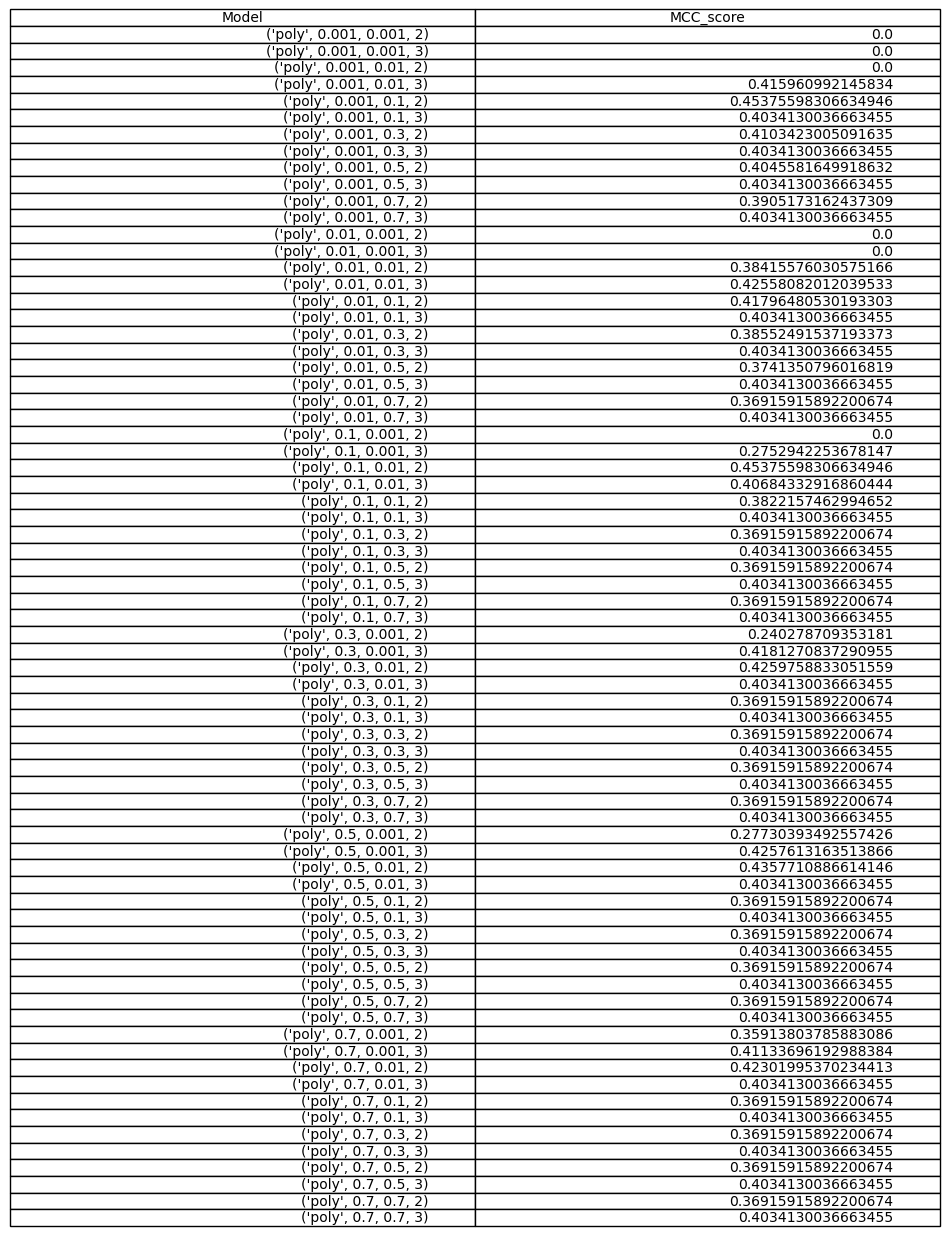

In [168]:
#save MCC Score table as pdf
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

fig, ax =plt.subplots(figsize=(12,4))
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=Model_MCC_Table.values,colLabels=Model_MCC_Table.columns,loc='center')

pp = PdfPages("linear_scores.pdf")
pp.savefig(fig, bbox_inches='tight')
pp.close()

In [ ]:
value_counts = data['PQ11'].value_counts()
print(value_counts)

In [154]:
#run variable dropping on Group 1 responses

#reindex indices of test data from 0 
X_test = X_test.reset_index()
del X_test['index']
y_test = y_test.reset_index()
del y_test['index']

#store best model from grid search
from sklearn import svm, datasets
model_SVC = svm.SVC()
import itertools
import time
from sklearn.metrics import matthews_corrcoef

bestmodel = svm.SVC(kernel='linear',C=0.3)#, gamma=0.001,degree=2)

#dropping variables to select predictors for best model

#initialize max_MCC_score list
max_MCC_score=[]

#initialize predictor_removed list
predictor_removed=[]

#initialize number of predictors list
num_predictors=[]

while len(num_predictors)!=177: 

    #initialize MCC_score list
    MCC_score=[]
    #initialize predictor list
    predictor=[]

    #for every predictor 
    for i in range(X_test.shape[1]):
                
        #remove the predictor from data sets
        ColumnName=X_test.columns[i] #store the column name of ith predictor in X_test 
        PREDICTORTEST=X_test[ColumnName] #define the column of ith predictor in X_test 
        PREDICTORTRAIN=X_train[ColumnName] #define the column of ith predictor in X_train
        print(f"Testing predictor {i+1}/{X_test.shape[1]}: {ColumnName}")
        print(f"Shape of PREDICTORTEST: {PREDICTORTEST.shape}")  # Print the shape
        X_test=X_test.drop(ColumnName, axis=1) #remove ith predictor from testing (copy) data 
        X_train=X_train.drop(ColumnName,axis=1) #remove ith predictor from training data
        
        #store predictor in predictor list
        predictor.append(ColumnName) #store name of ith predictor in predictor list 
        
        #train model on train set
        bestmodel.fit(X_train, np.ravel(y_train.transpose().to_numpy())) #train our best model on the training data
        
        #test model on test set
        pred=bestmodel.predict(X_test) #test our best model on unseen testing data 

        #store MCC score after removal 
        MCC=matthews_corrcoef(y_test,pred) #compute MCC score for our new model with ith predictor removed
        MCC_score.append(MCC) #add this MCC score to our list in entry i
        
        #add ith predictor back to data and repeat with next predictor
        X_test.insert(i, ColumnName, PREDICTORTEST)
        X_train.insert(i, ColumnName, PREDICTORTRAIN)
    
    #select jth MCC score that is the highest in MCC_score list
    j=MCC_score.index(max(MCC_score))
    
    #identify jth predictor corresponding to max MCC score 
    max_pred=predictor[j]
    max_ColumnName=X_test.columns[j] #store the column name of jth predictor in X_test 
    max_PREDICTORTEST=X_test[max_ColumnName] #define the column of jth predictor in X_test 
    
    #store jth MCC score in max_MCC_score list
    max_MCC_score.append(max(MCC_score))
    
    #store jth predictor in predictor_removed list
    predictor_removed.append(max_pred)
    
    #remove jth predictor from train and test data
    X_test=X_test.drop(max_ColumnName, axis=1) #remove jth predictor from testing data 
    X_train=X_train.drop(max_ColumnName,axis=1) #remove jth predictor from training data
    print(f"Number of predictors left after removal: {X_test.shape[1]}")
    
    #compute length of new data and store in number of predictors list
    num_predictors.append(X_test.shape[1])
    
#append last remaining predictor to predictor_removed list
predictor_removed.append(X_train.columns[0])
#append MCC=0 to max_MCC_score since removing the last predictor results in a MCC zero
max_MCC_score.append(0)
#append "0" to num_predictors since we're removing the last predictor
num_predictors.append(0)
    
#concatenate predictor_removed, max_MCC_score, number of predictors, and percent yes/no lists as column vectors into one table 
predictor_removed_df=pd.DataFrame(predictor_removed,columns=['Predictor Removed'])
max_MCC_score_df=pd.DataFrame(max_MCC_score,columns=['MCC Score After Removal'])
num_predictors_df=pd.DataFrame(num_predictors,columns=['Predictors Left'])
Results=pd.concat([predictor_removed_df,max_MCC_score_df,num_predictors_df], axis=1)
#invert 2nd column of PQ1_model to get ranks
Results.iloc[:,2]=Results.iloc[::-1,2].values
Results.iloc[:,2]=Results.iloc[:,2]+1
#rename 2nd column as rank (order in which vars are removed)
Results = Results.rename(columns={'Predictor Removed': 'Predictor Removed', 'MCC Score After Removal': 'MCC Score After Removal', 'Predictors Left':'Rank'})

Results

Testing predictor 1/178: Videonewsstory
Shape of PREDICTORTEST: (273,)
Testing predictor 2/178: LengthofVideoInSeconds
Shape of PREDICTORTEST: (273,)
Testing predictor 3/178: ForceLocation
Shape of PREDICTORTEST: (273,)
Testing predictor 4/178: LocNoiseLevel
Shape of PREDICTORTEST: (273,)
Testing predictor 5/178: LocationIsolated
Shape of PREDICTORTEST: (273,)
Testing predictor 6/178: Bystanders
Shape of PREDICTORTEST: (273,)
Testing predictor 7/178: OfficersPresent
Shape of PREDICTORTEST: (273,)
Testing predictor 8/178: Resistance
Shape of PREDICTORTEST: (273,)
Testing predictor 9/178: StateOfControl
Shape of PREDICTORTEST: (273,)
Testing predictor 10/178: DeEscalation
Shape of PREDICTORTEST: (273,)
Testing predictor 11/178: SusNegEmotionalState
Shape of PREDICTORTEST: (273,)
Testing predictor 12/178: OffNegEmotionalState
Shape of PREDICTORTEST: (273,)
Testing predictor 13/178: PQ1
Shape of PREDICTORTEST: (273,)
Testing predictor 14/178: PQ2
Shape of PREDICTORTEST: (273,)
Testing pred

Predictor Removed  MCC Score After Removal  Rank
0                       PQ2                 0.821073     1
1             conscientious                 0.832241     2
2    LengthofVideoInSeconds                 0.832241     3
3          LocationIsolated                 0.832241     4
4                Bystanders                 0.832241     5
..                      ...                      ...   ...
173                     obs                 0.769377   174
174                     PQ6                 0.769377   175
175            affectionate                 0.728855   176
176                    PQ10                 0.691398   177
177                     PQ4                 0.000000   178

[178 rows x 3 columns]

In [228]:
#change directory to store Reuslts
import os
os.chdir("C:/Users/eliza/OneDrive/Documents/Perceptions of UofF Research/March Research Update 2024/Variable Dropping")

In [155]:
#save Results table as a pdf

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Assuming Results is your DataFrame containing the data for the table

fig, ax = plt.subplots(figsize=(12, 4))
ax.axis('tight')
ax.axis('off')

the_table = ax.table(cellText=Results.values, colLabels=Results.columns, loc='center')

# Add the table to the figure
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)
the_table.scale(1.2, 1.2)  # Adjust the scale as needed

# Save the figure as a PDF
with PdfPages("PQ11_Var_Drop.pdf") as pdf:
    pdf.savefig(fig, bbox_inches='tight')

plt.close(fig)

In [156]:
#obtain only relevant preds
Relevant_Preds_PQ11=Results.iloc[165-1:178,]
Relevant_Preds_PQ11

fig, ax = plt.subplots(figsize=(12, 4))
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=Relevant_Preds_PQ11.values, colLabels=Relevant_Preds_PQ11.columns, loc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)
the_table.scale(1.2, 1.2)  

with PdfPages("Relevant_Preds_PQ11.pdf") as pdf:
    pdf.savefig(fig, bbox_inches='tight')
plt.close(fig)

In [157]:
#visualize relevant predictors table
Relevant_Preds_PQ11

Predictor Removed  MCC Score After Removal  Rank
164            Group2                 0.843718   165
165     DetainedCuffs                 0.832241   166
166        softspoken                 0.830989   167
167        Resistance                 0.818183   168
168            liable                 0.806459   169
169      conventional                 0.793442   170
170               PQ8                 0.759779   171
171   OfficersPresent                 0.769377   172
172     LocNoiseLevel                 0.769377   173
173               obs                 0.769377   174
174               PQ6                 0.769377   175
175      affectionate                 0.728855   176
176              PQ10                 0.691398   177
177               PQ4                 0.000000   178

In [136]:
#store predictors and response for relevant preds
predictors=data[Relevant_Preds_PQ11.iloc[:,0]]
response=data["PQ11"]

In [137]:
#check preds match table 
predictors.head(10)

WSUCorpsPrevious  PQ6  PQ8  loveschildren  symracismq5 DetainedNoCuffs  \
0                0  1.0  0.0              2            2               1   
1                0  1.0  0.0              7            2               0   
2                0  1.0  0.0              5            3               0   
3                0  4.0  0.0              5            1               0   
4                0  9.0  4.0              3            2               0   
5                0  1.0  0.0              5            2               0   
6                0  3.0  0.0              6            1               0   
7                0  2.0  0.0              4            2               0   
8                0  1.0  0.0              4            2               0   
9                0  2.0  0.0              2            1               0   

   ambitious MovingRightSpeed WSUCorpsCurrent  analytical  ... Group1  \
0          6                1               0           5  ...      0   
1          7                1               1           7  ...      0   
2          5                0               0           5  ...      1   
3          5                1               0           6  ...      1   
4          5                1               0           7  ...      0   
5          5                1               0           6  ...      1   
6          6                1               1           5  ...      1   
7          6                1               0           5  ...      0   
8          6                1               1           6  ...      1   
9          7                1               1           5  ...      1   

  CoderLiberal Group2 doesntuseharshlang  WSUNoCorps childlike PoliceQ2  \
0            0      1                  4           1         2        4   
1            0      1                  3           0         2        4   
2            1      0                  1           1         1        5   
3            0      0                  4           1         3        4   
4            1      1                  3           1         2        4   
5            0      0                  5           1         2        4   
6            0      0                  3           0         2        3   
7            0      1                  3           1         3        4   
8            1      0                  7           0         5        3   
9            0      0                  4           0         2        4   

  GoingTooSlow  PQ11  PQ9  
0            0   3.0  5.0  
1            0   5.0  5.0  
2            1   3.0  4.0  
3            1   3.0  4.0  
4            0   5.0  5.0  
5            0   3.0  5.0  
6            1   4.0  5.0  
7            0   5.0  4.0  
8            0   1.0  3.0  
9            1   4.0  5.0  

[10 rows x 25 columns]

In [138]:
#check response is correct
response.head(10)

0    0.0
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
6    1.0
7    0.0
8    1.0
9    1.0
Name: PQ10, dtype: float64

In [139]:
#computation p-values of MCC (use permutation testing)
from sklearn import svm, datasets
model_SVC = svm.SVC()
import itertools
import time
from sklearn.metrics import matthews_corrcoef
import pandas as pd

num_permutations=500 #number of times to permute (shuffle) PQ# responses
observed_mcc=0. #computed MCC of reduced model for PQ# with specified cutoff value
permuted_mcc_scores=[] #initialize a list to store the MCC scores after each of the permutations of PQ#
bestmodel = svm.SVC(kernel='linear',C=0.01)#,gamma=0.001,degree=2)#best model for PQ# with specified cutoff value

#store MCC scores for each of our reduced model predictions in a data frame
for permutation in range(num_permutations): #for each permutation
    
    permuted_response=np.random.permutation(response) #permute the row entries of 'PQ#' in reduced data    
    print(f"Permutation {permutation + 1} - Permuted Response: {permuted_response}")
    
    #create training/test split on reduced data set
    X_train, X_test, y_train, y_test = train_test_split(predictors, permuted_response, test_size = 0.214)
    y_train=pd.DataFrame(y_train,columns=['PQ11'])
    
    #train model on reduced data with permuted response
    bestmodel.fit(X_train, np.ravel(y_train.transpose().to_numpy())) 
                                  
    #make predictions for response using trained model. 
    pred=bestmodel.predict(X_test) 

    #store MCC score with permuted response
    MCC=matthews_corrcoef(y_test,pred) 
    permuted_mcc_scores.append(MCC) #add this MCC score to our list 
    print(f"Permutation {permutation + 1} - MCC: {MCC:.4f}")
    
#compute the p-value(the probability that the observed MCC of 0.598 occured by random chance) 
    #null: MCC!=observed_mcc 
    #alternative: MCC=observed_mcc
    #p<0.05 means we reject the null and MCC=observed_mcc (our MCC is significant - didn't occur by random chance)
    #p>=0.05 means we accept the null and MCC!=observed_mcc (our MCC is not significant - did occur by random chance)
permuted_mcc_scores = np.array(permuted_mcc_scores)
p_value = np.mean(permuted_mcc_scores >= observed_mcc) #compute the proportion of permuted MCC scores that are at least as large as the observed MCC
p_value = round(p_value, 100)  #round to 100 decimal places
scientific_notation = "{:.10e}".format(p_value) #display in scientific notation
p_value 

Permutation 1 - Permuted Response: [0. 0. 0. ... 0. 0. 0.]
Permutation 1 - MCC: 0.0000
Permutation 2 - Permuted Response: [0. 0. 0. ... 0. 1. 0.]
Permutation 2 - MCC: 0.0000
Permutation 3 - Permuted Response: [0. 0. 0. ... 0. 0. 0.]
Permutation 3 - MCC: 0.0000
Permutation 4 - Permuted Response: [0. 0. 0. ... 0. 0. 0.]
Permutation 4 - MCC: 0.0000
Permutation 5 - Permuted Response: [0. 0. 0. ... 0. 0. 0.]
Permutation 5 - MCC: 0.0000
Permutation 6 - Permuted Response: [0. 1. 0. ... 0. 0. 0.]
Permutation 6 - MCC: 0.0000
Permutation 7 - Permuted Response: [0. 0. 0. ... 0. 0. 0.]
Permutation 7 - MCC: 0.0000
Permutation 8 - Permuted Response: [0. 0. 0. ... 0. 0. 0.]
Permutation 8 - MCC: 0.0000
Permutation 9 - Permuted Response: [1. 0. 0. ... 0. 0. 0.]
Permutation 9 - MCC: 0.0000
Permutation 10 - Permuted Response: [0. 0. 0. ... 1. 0. 0.]
Permutation 10 - MCC: 0.0000
Permutation 11 - Permuted Response: [0. 0. 0. ... 0. 1. 0.]
Permutation 11 - MCC: 0.0000
Permutation 12 - Permuted Response: [0.

0.0

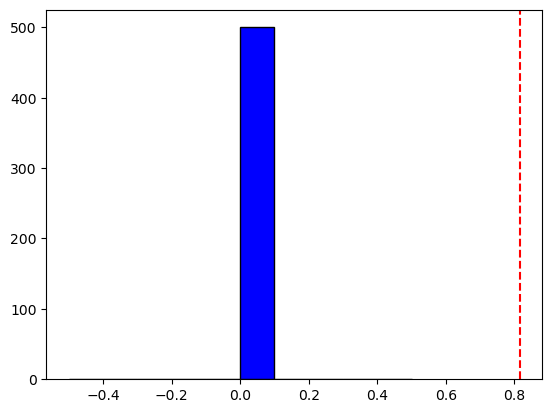

In [145]:
#plot i.e. histogram of permuted_mcc_scores
import matplotlib.pyplot as plt

plt.hist(permuted_mcc_scores, bins=10, color='blue', edgecolor='black')
plt.axvline(x=observed_mcc, color='red', linestyle='--', label='Observed Value')
#plt.savefig('MCC_Permutation_Testing_PQ11.png')
plt.show()

In [ ]:
#run var drop on PQS with either grouping as relevant predictors

In [9]:
#list of relevant preds from PQ's with either group as relevant
PQ1_relevant_preds=['GivenCitation', 'symracismq1', 'PoliceQ8', 'symracismq3', 'PQ5',
       'Group2', 'PQ10', 'tactful', 'AfricanBlackCoder', 'PQ7',
       'LocNoiseLevel', 'GoingTooSlow', 'tender', 'conventional', 'PQ3',
       'symracismq7', 'childlike', 'PoliceQ2', 'MaleSuspect',
       'symracismq5', 'PQ4', 'OffPhysicalDeEscalation', 'PQ8', 'PQ6']

PQ2_relevant_preds=['Group2', 'AfricanBlackCoder', 'SuspectDisplayWeapon', 'PQ11',
       'PhysicalArrestCuffs', 'PushTooFast', 'WhiteCoder', 'athletic',
       'VerbalStatementArrest', 'PQ9', 'independent', 'forceful',
       'symracismq8', 'PoliceQ6', 'GivenCitation', 'ambitious', 'solemn',
       'ForceLocation', 'cheeful', 'PoliceQ1', 'PoliceQ5', 'WSUNoCorps',
       'sincere', 'OffSilentAfterForce', 'dominant', 'strongpersonality',
       'less5mintocode', 'analytical', 'theatrical',
       'OffPhysicalDeEscalation', 'DetainedNoCuffs', 'tactful',
       'DetainedCuffs', 'loveschildren', 'symracismq3', 'competitive',
       'PoliceQ4', 'Bystanders', 'PoliceQ9', 'selfsufficient',
       'unsystematic', 'senstivetoothersneeds', 'obs', 'aggressive',
       'eagertosoothhurt', 'PQ6', 'PQ3', 'unpredictable', 'Resistance',
       'PQ1', 'PoliceQ10', 'OfficersPresent', 'conscientious', 'PQ5',
       'PQ7', 'PQ10', 'flatterable', 'feminine', 'reliable',
       'sympathetic', 'leadershipskills', 'compassionate', 'liable',
       'warm', 'tender', 'gullible', 'adaptable', 'individualistic',
       'PoliceQ8']

PQ4_relevant_preds=['WSUCorpsPrevious', 'PoliceQ9', 'Group2', 'willingtotakerisks',
       'happy', 'feminine', 'analytical', 'willingtotakestand',
       'eagertosoothhurt', 'inefficient', 'doesntuseharshlang',
       'loveschildren', 'loyal', 'symracismq7', 'dominant',
       'DetainedCuffs', 'unsystematic', 'PoliceQ1',
       'UnknownSuspectGender', 'SuspectUnarmed', 'less5mintocode',
       'MaleSuspect', 'OffSilentAfterForce', 'CoderLiberal', 'PoliceQ2',
       'WhiteCoder', 'AfricanBlackCoder', 'HispanicLatinoCoder',
       'WSUCorpsCurrent', 'WSUNoCorps', 'Group1', 'actsasaleader',
       'symracismq4', 'conventional', 'PoliceQ3', 'liable',
       'selfsufficient', 'warm', 'solemn', 'bsri', 'PQ1', 'PQ8',
       'athletic', 'individualistic', 'symracismq3',
       'VerbalStatementArrest', 'competitive', 'SuspectDisplayWeapon',
       'softspoken', 'senstivetoothersneeds', 'gullible', 'tender',
       'PoliceQ4', 'compassionate', 'PoliceQ5', 'PQ6',
       'makesdecisioneasy', 'flatterable', 'tactful', 'sympathetic',
       'PoliceQ7', 'PoliceQ6', 'PoliceQ10', 'PoliceQ8', 'gentle', 'PQ2',
       'truthful', 'understanding', 'friendly', 'adaptable', 'ambitious',
       'PQ3', 'obs']

PQ7_relevant_preds=['Group2', 'SuspectDisplayWeapon', 'PushTooFast',
       'SusNegEmotionalState', 'softspoken', 'OffPhysicalDeEscalation',
       'ambitious', 'PQ10', 'WSUNoCorps', 'PoliceQ3', 'PoliceQ1',
       'VerbalStatementArrest', 'DetainedCuffs', 'WhiteSuspect',
       'PhysicalArrestCuffs', 'WhiteCoder', 'warm', 'gullible',
       'individualistic', 'PQ5', 'PQ11', 'obs', 'dominant',
       'CoderLiberal', 'symracismq2', 'PoliceQ10', 'unsystematic',
       'AfricanBlackCoder', 'PQ9', 'doesntuseharshlang', 'PQ6', 'PQ3']

PQ8_relevant_preds=['Group2', 'OffPhysicalDeEscalation', 'WSUNoCorps', 'PQ11']

PQ10_relevant_preds=['WSUCorpsPrevious', 'PQ6', 'PQ8', 'loveschildren', 'symracismq5',
       'DetainedNoCuffs', 'ambitious', 'MovingRightSpeed',
       'WSUCorpsCurrent', 'analytical', 'DetainedCuffs',
       'AfricanBlackCoder', 'VerbalStatementArrest', 'PushTooFast', 'PQ2',
       'Group1', 'CoderLiberal', 'Group2', 'doesntuseharshlang',
       'WSUNoCorps', 'childlike', 'PoliceQ2', 'GoingTooSlow', 'PQ11',
       'PQ9']

PQ11_relevant_preds=['Group2', 'DetainedCuffs', 'softspoken', 'Resistance', 'liable',
       'conventional', 'PQ8', 'OfficersPresent', 'LocNoiseLevel', 'obs',
       'PQ6', 'affectionate', 'PQ10', 'PQ4']

In [147]:
#group1 responses 
data1=data.loc[data['Group1']==1,:]
#group2 responses 
data2=data.loc[data['Group2']==1,:]

#group1 (group2) responses with relevant vars
data1_relevant_vars_only=pd.concat([data1[PQ2_relevant_preds],data1['PQ2']],axis=1)
data2_relevant_vars_only=pd.concat([data2[PQ2_relevant_preds],data2['PQ2']],axis=1)
#check num preds is correct
data1_relevant_vars_only.shape[1]

70

In [148]:
#compute training and testing subsets for variable-dropping on group 1 (or group 2)
X=data2_relevant_vars_only.drop(['PQ2'], axis=1) #explanatory vars
y=data2_relevant_vars_only['PQ2'] #response

#split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.262)#0.259 group1, 0.262 group2

#construct training data
y_train=pd.DataFrame(y_train,columns=['PQ2'])
y_train.head()
y_train.shape
training_data=pd.concat([X_train,y_train],axis=1)
training_data.shape
training_data

Group2 AfricanBlackCoder SuspectDisplayWeapon  PQ11 PhysicalArrestCuffs  \
812       1                 1                    1   1.0                   1   
770       1                 0                    1   1.0                   1   
1159      1                 0                    1   2.0                   1   
1123      1                 0                    1   2.0                   0   
1215      1                 1                    1   5.0                   0   
742       1                 0                    1   1.0                   1   
350       1                 1                    1   1.0                   0   
1071      1                 0                    1   1.0                   0   
534       1                 1                    1   2.0                   0   
582       1                 1                    1   1.0                   0   
147       1                 1                    1   3.0                   1   
1113      1                 1                    1   1.0                   0   
548       1                 0                    1   1.0                   1   
292       1                 1                    1   1.0                   1   
945       1                 0                    0   1.0                   0   
256       1                 1                    1   5.0                   0   
424       1                 0                    1   4.0                   0   
987       1                 0                    1   3.0                   1   
444       1                 0                    1   4.0                   0   
171       1                 0                    1   3.0                   0   
236       1                 0                    0   1.0                   1   
161       1                 0                    1   2.0                   1   
923       1                 0                    0   3.0                   0   
385       1                 0                    1   2.0                   0   
1088      1                 1                    1   1.0                   1   
786       1                 1                    1   1.0                   0   
846       1                 0                    1   1.0                   0   
657       1                 1                    1   5.0                   0   
1039      1                 0                    0   1.0                   0   
1105      1                 0                    0   2.0                   0   
91        1                 1                    1   4.0                   1   
288       1                 0                    1   5.0                   0   
662       1                 0                    1   5.0                   0   
128       1                 0                    0   1.0                   0   
207       1                 0                    0   1.0                   1   
636       1                 0                    0   1.0                   0   
198       1                 0                    0   1.0                   0   
539       1                 0                    1   1.0                   1   
1054      1                 1                    0   1.0                   1   
72        1                 1                    1   5.0                   0   
1074      1                 0                    0   1.0                   0   
227       1                 0                    1   5.0                   0   
1087      1                 0                    0   1.0                   0   
244       1                 0                    1   1.0                   1   
780       1                 0                    1   1.0                   0   
228       1                 0                    1   4.0                   0   
524       1                 1                    0   1.0                   1   
907       1                 0                    0   1.0                   0   
69        1                 0                    1   4.0                   0   
715  

In [149]:
#run variable dropping on Group 1 (or Group 2) responses
#reindex indices of test data from 0 
X_test = X_test.reset_index()
del X_test['index']
y_test = y_test.reset_index()
del y_test['index']

#store best model from grid search
from sklearn import svm, datasets
model_SVC = svm.SVC()
import itertools
import time
from sklearn.metrics import matthews_corrcoef

bestmodel = svm.SVC(kernel='poly', C=0.001, gamma=0.01,degree=3)

#dropping variables to select predictors for best model

#initialize percent yes (no) response list
percent_yes=[]

#initialize max_MCC_score list
max_MCC_score=[]

#initialize predictor_removed list
predictor_removed=[]

#initialize number of predictors list
num_predictors=[]

while len(num_predictors)!=(data1_relevant_vars_only.shape[1]-2): 

    #initialize MCC_score list
    MCC_score=[]
    #initialize predictor list
    predictor=[]

    #for every predictor 
    for i in range(X_test.shape[1]):
                
        #remove the predictor from data sets
        ColumnName=X_test.columns[i] #store the column name of ith predictor in X_test 
        PREDICTORTEST=X_test[ColumnName] #define the column of ith predictor in X_test 
        PREDICTORTRAIN=X_train[ColumnName] #define the column of ith predictor in X_train
        print(f"Testing predictor {i+1}/{X_test.shape[1]}: {ColumnName}")
        print(f"Shape of PREDICTORTEST: {PREDICTORTEST.shape}")  # Print the shape
        X_test=X_test.drop(ColumnName, axis=1) #remove ith predictor from testing (copy) data 
        X_train=X_train.drop(ColumnName,axis=1) #remove ith predictor from training data
        
        #store predictor in predictor list
        predictor.append(ColumnName) #store name of ith predictor in predictor list 
        
        #train model on train set
        bestmodel.fit(X_train, np.ravel(y_train.transpose().to_numpy())) #train our best model on the training data
        
        #test model on test set
        pred=bestmodel.predict(X_test) #test our best model on unseen testing data 

        #store MCC score after removal 
        MCC=matthews_corrcoef(y_test,pred) #compute MCC score for our new model with ith predictor removed
        MCC_score.append(MCC) #add this MCC score to our list in entry i
        
        #add ith predictor back to data and repeat with next predictor
        X_test.insert(i, ColumnName, PREDICTORTEST)
        X_train.insert(i, ColumnName, PREDICTORTRAIN)
    
    #select jth MCC score that is the highest in MCC_score list
    j=MCC_score.index(max(MCC_score))
    
    #identify jth predictor corresponding to max MCC score 
    max_pred=predictor[j]
    max_ColumnName=X_test.columns[j] #store the column name of jth predictor in X_test 
    max_PREDICTORTEST=X_test[max_ColumnName] #define the column of jth predictor in X_test 
    
    #store jth MCC score in max_MCC_score list
    max_MCC_score.append(max(MCC_score))
    
    #store jth predictor in predictor_removed list
    predictor_removed.append(max_pred)
    
    #remove jth predictor from train and test data
    X_test=X_test.drop(max_ColumnName, axis=1) #remove jth predictor from testing data 
    X_train=X_train.drop(max_ColumnName,axis=1) #remove jth predictor from training data
    print(f"Number of predictors left after removal: {X_test.shape[1]}")
    
    #compute length of new data and store in number of predictors list
    num_predictors.append(X_test.shape[1])
    
    #compute store percent yes and no resp after var removed
    bestmodel.fit(X_train,np.ravel(y_train.transpose().to_numpy()))
    pred=bestmodel.predict(X_test)
    percent_yes.append((pred[pred==1].sum()/len(pred))*100)

#append last remaining predictor to predictor_removed list
predictor_removed.append(X_train.columns[0])
#append MCC=0 to max_MCC_score since removing the last predictor results in a MCC zero
max_MCC_score.append(0)
#append "0" to num_predictors since we're removing the last predictor
num_predictors.append(0)
#append percnet yes (no) responses with last var in training data
bestmodel.fit(X_train,np.ravel(y_train.transpose().to_numpy()))
pred=bestmodel.predict(X_test)
percent_yes.append((pred[pred==1].sum()/len(pred))*100)

#concatenate predictor_removed, max_MCC_score, and number of predictors lists as column vectors into one table 
predictor_removed_df=pd.DataFrame(predictor_removed,columns=['Predictor Removed'])
max_MCC_score_df=pd.DataFrame(max_MCC_score,columns=['MCC Score After Removal'])
num_predictors_df=pd.DataFrame(num_predictors,columns=['Predictors Left'])
percent_yes_df=pd.DataFrame(percent_yes,columns=['Percent Yes Predictions'])
Results=pd.concat([predictor_removed_df,max_MCC_score_df,num_predictors_df,percent_yes_df], axis=1)
#invert 2ndd column of PQ1_model to get ranks
Results.iloc[:,2]=Results.iloc[::-1,2].values
Results.iloc[:,2]=Results.iloc[:,2]+1
#rename 2ndd column as rank (order in which vars are removed)
Results = Results.rename(columns={'Predictor Removed': 'Predictor Removed', 'MCC Score After Removal': 'MCC Score After Removal', 'Predictors Left':'Rank', 'Percent Yes Predictions': '% Yes Predictions After Removal'})
Results['% No Predictions After Removal']=100-Results['% Yes Predictions After Removal']
Results

Testing predictor 1/69: Group2
Shape of PREDICTORTEST: (168,)
Testing predictor 2/69: AfricanBlackCoder
Shape of PREDICTORTEST: (168,)
Testing predictor 3/69: SuspectDisplayWeapon
Shape of PREDICTORTEST: (168,)
Testing predictor 4/69: PQ11
Shape of PREDICTORTEST: (168,)
Testing predictor 5/69: PhysicalArrestCuffs
Shape of PREDICTORTEST: (168,)
Testing predictor 6/69: PushTooFast
Shape of PREDICTORTEST: (168,)
Testing predictor 7/69: WhiteCoder
Shape of PREDICTORTEST: (168,)
Testing predictor 8/69: athletic
Shape of PREDICTORTEST: (168,)
Testing predictor 9/69: VerbalStatementArrest
Shape of PREDICTORTEST: (168,)
Testing predictor 10/69: PQ9
Shape of PREDICTORTEST: (168,)
Testing predictor 11/69: independent
Shape of PREDICTORTEST: (168,)
Testing predictor 12/69: forceful
Shape of PREDICTORTEST: (168,)
Testing predictor 13/69: symracismq8
Shape of PREDICTORTEST: (168,)
Testing predictor 14/69: PoliceQ6
Shape of PREDICTORTEST: (168,)
Testing predictor 15/69: GivenCitation
Shape of PREDIC

Predictor Removed  MCC Score After Removal  Rank  \
0                       obs                 0.396965     1   
1                    Group2                 0.396965     2   
2         AfricanBlackCoder                 0.396965     3   
3      SuspectDisplayWeapon                 0.396965     4   
4                      PQ11                 0.396965     5   
5                analytical                 0.401288     6   
6               flatterable                 0.419248     7   
7       PhysicalArrestCuffs                 0.419248     8   
8               PushTooFast                 0.419248     9   
9                  athletic                 0.419248    10   
10               WhiteCoder                 0.419248    11   
11              symracismq8                 0.419248    12   
12            GivenCitation                 0.419248    13   
13            ForceLocation                 0.419248    14   
14               WSUNoCorps                 0.419248    15   
15      OffSilentAfterForce                 0.419248    16   
16           less5mintocode                 0.419248    17   
17          DetainedNoCuffs                 0.419248    18   
18               Bystanders                 0.423203    19   
19                      PQ9                 0.423203    20   
20                 gullible                 0.440968    21   
21            DetainedCuffs                 0.440968    22   
22    VerbalStatementArrest                 0.440968    23   
23                 forceful                 0.440968    24   
24  OffPhysicalDeEscalation                 0.440968    25   
25                 PoliceQ1                 0.423203    26   
26                 PoliceQ4                 0.423203    27   
27                   solemn                 0.427861    28   
28               Resistance                 0.427861    29   
29                  sincere                 0.427861    30   
30                 PoliceQ6                 0.427861    31   
31              symracismq3                 0.427861    32   
32                 dominant                 0.406290    33   
33                 reliable                 0.423203    34   
34            unpredictable                 0.423203    35   
35                ambitious                 0.423203    36   
36           selfsufficient                 0.423203    37   
37              independent                 0.390148    38   
38                 feminine                 0.378815    39   
39                 PoliceQ5                 0.378815    40   
40            loveschildren                 0.378815    41   
41                  tactful                 0.378815    42   
42          OfficersPresent                 0.367966    43   
43            compassionate                 0.384224    44   
44               theatrical                 0.355722    45   
45                  cheeful                 0.331935    46   
46         eagertosoothhurt                 0.338383    47   
47              competitive                 0.338383    48   
48                 PoliceQ9                 0.338383    49   
49               aggressive                 0.338383    50   
50          individualistic                 0.281925    51   
51                      PQ6                 0.284491    52   
52                      PQ1                 0.317197    53   
53             unsystematic                 0.287255    54   
54    senstivetoothersneeds                 0.176806    55   
55                PoliceQ10                 0.126905    56   
56                      PQ3                 0.000000    57   
57        strongpersonality                 0.000000    58   
58            conscientious                 0.000000    59   
59                      PQ5                 0.000000    60   
60                      PQ7                 0.000000    61   
61                     PQ10                 0.000000    62   
62              sympathetic                 0.000000    63   
63         leadershipskills               

In [13]:
#change dir..
import os
os.chdir("C:/Users/eliza/OneDrive/Documents/Perceptions of UofF Research/March Research Update 2024/Variable Dropping/on group responses separately")

In [151]:
#visualize variable dropping results Group 1 (or Group 2)
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

Results_Group2=Results

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

Results_Group2

Predictor Removed  MCC Score After Removal  Rank  \
0                       obs                 0.396965     1   
1                    Group2                 0.396965     2   
2         AfricanBlackCoder                 0.396965     3   
3      SuspectDisplayWeapon                 0.396965     4   
4                      PQ11                 0.396965     5   
5                analytical                 0.401288     6   
6               flatterable                 0.419248     7   
7       PhysicalArrestCuffs                 0.419248     8   
8               PushTooFast                 0.419248     9   
9                  athletic                 0.419248    10   
10               WhiteCoder                 0.419248    11   
11              symracismq8                 0.419248    12   
12            GivenCitation                 0.419248    13   
13            ForceLocation                 0.419248    14   
14               WSUNoCorps                 0.419248    15   
15      OffSilentAfterForce                 0.419248    16   
16           less5mintocode                 0.419248    17   
17          DetainedNoCuffs                 0.419248    18   
18               Bystanders                 0.423203    19   
19                      PQ9                 0.423203    20   
20                 gullible                 0.440968    21   
21            DetainedCuffs                 0.440968    22   
22    VerbalStatementArrest                 0.440968    23   
23                 forceful                 0.440968    24   
24  OffPhysicalDeEscalation                 0.440968    25   
25                 PoliceQ1                 0.423203    26   
26                 PoliceQ4                 0.423203    27   
27                   solemn                 0.427861    28   
28               Resistance                 0.427861    29   
29                  sincere                 0.427861    30   
30                 PoliceQ6                 0.427861    31   
31              symracismq3                 0.427861    32   
32                 dominant                 0.406290    33   
33                 reliable                 0.423203    34   
34            unpredictable                 0.423203    35   
35                ambitious                 0.423203    36   
36           selfsufficient                 0.423203    37   
37              independent                 0.390148    38   
38                 feminine                 0.378815    39   
39                 PoliceQ5                 0.378815    40   
40            loveschildren                 0.378815    41   
41                  tactful                 0.378815    42   
42          OfficersPresent                 0.367966    43   
43            compassionate                 0.384224    44   
44               theatrical                 0.355722    45   
45                  cheeful                 0.331935    46   
46         eagertosoothhurt                 0.338383    47   
47              competitive                 0.338383    48   
48                 PoliceQ9                 0.338383    49   
49               aggressive                 0.338383    50   
50          individualistic                 0.281925    51   
51                      PQ6                 0.284491    52   
52                      PQ1                 0.317197    53   
53             unsystematic                 0.287255    54   
54    senstivetoothersneeds                 0.176806    55   
55                PoliceQ10                 0.126905    56   
56                      PQ3                 0.000000    57   
57        strongpersonality                 0.000000    58   
58            conscientious                 0.000000    59   
59                      PQ5                 0.000000    60   
60                      PQ7                 0.000000    61   
61                     PQ10                 0.000000    62   
62              sympathetic                 0.000000    63   
63         leadershipskills               

In [15]:
!pip install dataframe_image

In [152]:
#store relevant preds from variable dropping results Group 1 (or Group 2)
import seaborn as sns
import dataframe_image as dfi 

def highlight_rows(row, relevant_row_min):
    if row.name >= relevant_row_min:
        return 'background-color: rgba(255, 255, 0, 0.5)'
    else:
        return ['']*len(row)

# Set the row number from which you want to highlight
relevant_row_min = len(Results_Group2) - 45

# Apply the styling function to the DataFrame
styled_df_2 = Results_Group2.style.apply(highlight_rows, relevant_row_min=relevant_row_min, axis=1)

# Display the styled DataFrame
styled_df_2

dfi.export(styled_df_2,'Relevant_Pred_Results_PQ2_Group2.png')

In [153]:
#define relevant predictors in each group
PQ2_relevant_preds_Group1=np.array(Results_Group1.iloc[21:Results_Group1.shape[0],0]) 
PQ2_relevant_preds_Group2=np.array(Results_Group2.iloc[24:Results_Group2.shape[0],0]) 
PQ2_relevant_preds_Group1=pd.DataFrame(PQ2_relevant_preds_Group1)
PQ2_relevant_preds_Group2=pd.DataFrame(PQ2_relevant_preds_Group2)

In [154]:
#create a table to compare ranks
predictor_removed=Results_Group1['Predictor Removed'].values
predictor_removed=pd.DataFrame(predictor_removed,columns=['Predictor Removed'])
rank_Group1=Results_Group1['Rank'].values
rank_Group1=pd.DataFrame(rank_Group1, columns=['Rank Group 1'])

rank_Group2=[]
for i in range(predictor_removed.shape[0]):
    pred=predictor_removed.iloc[i,0]
    row_index=Results_Group2.loc[Results_Group2['Predictor Removed']==pred].index[0]
    rank_Group2.append(Results_Group2.iloc[row_index,2])

rank_Group2=pd.DataFrame(rank_Group2,columns=['Rank Group 2'])
rank_comparison_group_PQ2=pd.concat([predictor_removed, rank_Group1, rank_Group2],axis=1)

fig, ax = plt.subplots(figsize=(12, 4))
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=rank_comparison_group_PQ2.values, colLabels=rank_comparison_group_PQ2.columns, loc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)
the_table.scale(1.2, 1.2)  

with PdfPages("rank_comparison_group_PQ2.pdf") as pdf:
    pdf.savefig(fig, bbox_inches='tight')
plt.close(fig)

In [158]:
#compute spearman's rank correlation coefficient
from scipy.stats import spearmanr
rho, p_value = spearmanr(rank_comparison_group_PQ2['Rank Group 1'], rank_comparison_group_PQ2['Rank Group 2'])
rho

0.5684325904274754

In [155]:
#identify relevant preds in common between both groups
PQ2_preds_in_common=np.intersect1d(PQ2_relevant_preds_Group1,PQ2_relevant_preds_Group2)
PQ2_preds_in_common=pd.DataFrame(PQ2_preds_in_common,columns=['Pred in Common'])
PQ2_preds_in_common

Pred in Common
0   OffPhysicalDeEscalation
1           OfficersPresent
2                       PQ1
3                      PQ10
4                       PQ3
5                       PQ6
6                       PQ7
7                  PoliceQ1
8                 PoliceQ10
9                  PoliceQ4
10                 PoliceQ5
11                 PoliceQ6
12                 PoliceQ8
13               Resistance
14                adaptable
15                ambitious
16                  cheeful
17            compassionate
18              competitive
19            conscientious
20                 dominant
21         eagertosoothhurt
22                 feminine
23          individualistic
24         leadershipskills
25                   liable
26            loveschildren
27                 reliable
28           selfsufficient
29    senstivetoothersneeds
30                  sincere
31                   solemn
32        strongpersonality
33              sympathetic
34              symracismq3
35                  tactful
36                   tender
37               theatrical
38             unsystematic
39                     warm

In [156]:
#construct data for map
mat_ranks=pd.DataFrame(index=range(2),columns=[f'{col}' for col in PQ2_preds_in_common['Pred in Common']])
Group=pd.DataFrame(index=range(2),columns=['Group'])
mat_ranks=pd.concat([Group,mat_ranks],axis=1)
mat_ranks['Group']=[1,2]

for i in range(PQ2_preds_in_common.shape[0]):
    pred=PQ2_preds_in_common.iloc[i,0]
    row_index=rank_comparison_group_PQ2.loc[rank_comparison_group_PQ2['Predictor Removed']==pred].index[0]
    mat_ranks.iloc[0,i+1]=rank_comparison_group_PQ2.iloc[row_index,1]
    mat_ranks.iloc[1,i+1]=rank_comparison_group_PQ2.iloc[row_index,2]
    
mat_ranks.iloc[:, 1:] = mat_ranks.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')
mat_ranks

Group  OffPhysicalDeEscalation  OfficersPresent  PQ1  PQ10  PQ3  PQ6  PQ7  \
0      1                       31               36   56    35   54   24   68   
1      2                       25               43   53    62   57   52   61   

   PoliceQ1  PoliceQ10  PoliceQ4  PoliceQ5  PoliceQ6  PoliceQ8  Resistance  \
0        29         48        38        34        27        63          47   
1        26         56        27        40        31        69          29   

   adaptable  ambitious  cheeful  compassionate  competitive  conscientious  \
0         69         61       41             60           40             53   
1         68         36       46             44           48             59   

   dominant  eagertosoothhurt  feminine  individualistic  leadershipskills  \
0        39                55        57               52                64   
1        33                47        39               51                64   

   liable  loveschildren  reliable  selfsufficient  senstivetoothersneeds  \
0      62             22        58              45                     46   
1      65             41        34              37                     55   

   sincere  solemn  strongpersonality  sympathetic  symracismq3  tactful  \
0       44      26                 50           59           43       37   
1       30      28                 58           63           32       42   

   tender  theatrical  unsystematic  warm  
0      65          33            23    49  
1      67          45            54    66

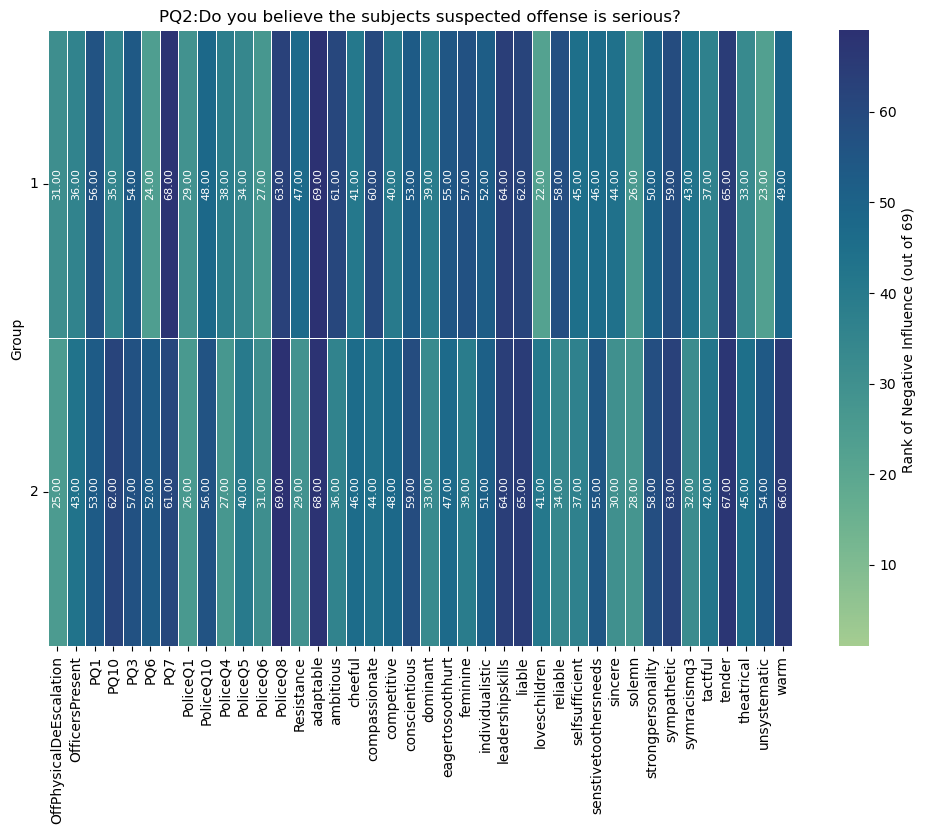

In [159]:
#produce heat map results
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
heatmap = sns.heatmap(mat_ranks.set_index('Group'), annot=False, fmt=".2f", cbar_kws={'label': 'Rank of Negative Influence (out of 69) '}, linewidths=.5, vmin=1, vmax=69, cmap="crest", annot_kws={"size": 8}, square=False)
for i, row in enumerate(heatmap.get_yticklabels()):
    for j, col in enumerate(heatmap.get_xticklabels()):
        mcc = mat_ranks.iloc[i, j + 1]
        if not pd.isna(mcc):  
            text_color = 'white' if mcc > 0.5 else 'black'
            heatmap.text(j + 0.5, i + 0.5, f'{mcc:.2f}', ha='center', va='center', color=text_color, fontsize=8, rotation='vertical')
            heatmap.set_yticklabels(['1', '2'], rotation=0)
plt.title('PQ2:Do you believe the subject''s suspected offense is serious?')
plt.savefig('PQ2_heatmap_normalized_rank_comparisons', bbox_inches='tight')
plt.show()